In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy
import tqdm
from ast import literal_eval
import json
from time import time
import os

In [19]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [20]:
rng = np.random.default_rng()

# Comparison

Setup moment and probability optimizations and compare results

Looking now at per cell capture efficiency values, also compare to correlation tests which are then affected by positive correlation introduced by downsampling

## Contents

- simulation of basic datasets e.g. varied interaction strength for different capture efficiencies (constant per dataset)
- pre-processing (bootstrap) and optimization setup for probabilities and moments
- correlation test analyis
- result comparison

# Simulation

## Code

### Sample simulation

Use gillespie algorithm to simulate a sample path of reaction network with given parameters, taking n samples from the stationary distribution

In [21]:
def gillespie(params, n, tmax=100, ts=10, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialize random generator
    rng = np.random.default_rng()

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)

    # convert to integers
    x1_samples = [int(x1) for x1 in x1_samples]
    x2_samples = [int(x2) for x2 in x2_samples]

    # re-combine to pairs of samples
    samples = list(zip(x1_samples, x2_samples))

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("Counts")
        plt.legend()
        plt.show()

    return samples

### Dataset simulation

Produce a dataset of pairs of samples simulated by gillespie with no downsampling (!)

Interaction strength decreases over dataset for testing

In [22]:
def simulate_dataset(cells, interaction_values):
    '''
    Produce a dataset of pairs of samples simulated with interaction strengths
    given by 'interaction_values' and sample size = cells

    Return count and parameter dataframes
    '''

    # number of pairs
    gene_pairs = len(interaction_values)

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # for each gene
    for i in tqdm.tqdm(range(gene_pairs)):

        # Set reaction rate parameters
        k_tx_1 = 1
        k_tx_2 = 1
        k_deg_1 = 1
        k_deg_2 = 1
        k_reg = interaction_values[i]

        # store parameters
        params_df.iloc[i] = [k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

        params = {
            'k_tx_1': k_tx_1,
            'k_tx_2': k_tx_2,
            'k_deg_1': k_deg_1,
            'k_deg_2': k_deg_2,
            'k_reg': k_reg
        }

        # simulate sample from model
        sample = gillespie(params, cells)

        # store counts
        counts_df.iloc[i] = sample

    return {'params_df': params_df, 'counts_df': counts_df}

### Downsampling simulation

Apply binomial downsampling to a dataset of samples given a capture efficiency vector

In [23]:
def simulate_downsampled_dataset(counts_df, beta):
    '''
    Apply capture efficiency vector 'beta' to produce downsampled dataset using
    the given 'count_df'
    '''

    # get dataset size
    gene_pairs, cells = counts_df.shape

    # error if incomptible cell numbers
    if not (cells == beta.shape[0]):
        print("Incompatible cell numbers")
        return None
    
    # initialize random generator
    rng = np.random.default_rng()

    # setup downsampled dataset
    downsampled_counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    for i in range(gene_pairs):

        # extract counts
        sample = counts_df.iloc[i]
        x1_sample = [x[0] for x in sample]
        x2_sample = [x[1] for x in sample]

        # downsample
        x1_sample_downsampled = rng.binomial(x1_sample, beta).tolist()
        x2_sample_downsampled = rng.binomial(x2_sample, beta).tolist()
        sample_downsampled = list(zip(x1_sample_downsampled, x2_sample_downsampled))
        
        # store counts
        downsampled_counts_df.iloc[i] = sample_downsampled

    return downsampled_counts_df

## Running

### Original dataset

In [24]:
# simulate original dataset
datasets = simulate_dataset(
    cells = 1000,
    interaction_values = [10, 5, 2, 1, 0.75, 0.5, 0.25, 0.1, 0]
)

100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


In [25]:
# store
datasets['params_df'].to_csv("./Test-Info/Data/params.csv")
datasets['counts_df'].to_csv("./Test-Info/Data/counts.csv")

### High capture

In [23]:
# sample a high capture
beta_high = rng.uniform(0.8, 1.0, size=1000)

In [26]:
# store
np.savetxt("./Test-Info/Data/beta_unif_high.csv", beta_high, delimiter=",")

In [27]:
# downsample dataset
counts_downsampled = simulate_downsampled_dataset(datasets['counts_df'], beta_high)

In [28]:
# store
counts_downsampled.to_csv("./Test-Info/Data/counts_unif_high.csv")

### Medium capture

In [121]:
# sample a medium capture
beta_medium = rng.uniform(0.4, 0.6, size=1000)

In [122]:
# store
np.savetxt("./Test-Info/Data/beta_unif_med.csv", beta_medium, delimiter=",")

In [123]:
# downsample dataset
counts_downsampled = simulate_downsampled_dataset(datasets['counts_df'], beta_medium)

In [124]:
# store
counts_downsampled.to_csv("./Test-Info/Data/counts_unif_med.csv")

### Low capture

In [138]:
# sample a low capture
beta_low = rng.uniform(0.1, 0.3, size=1000)

In [139]:
# store
np.savetxt("./Test-Info/Data/beta_unif_low.csv", beta_low, delimiter=",")

In [140]:
# downsample dataset
counts_downsampled = simulate_downsampled_dataset(datasets['counts_df'], beta_low)

In [141]:
# store
counts_downsampled.to_csv("./Test-Info/Data/counts_unif_low.csv")

### Alternate datasets

In [282]:
# simulate original dataset
datasets = simulate_dataset(
    cells = 1000,
    interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.8, 0.6, 0.4, 0.2, 0.1, 0]
)

100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


In [283]:
# store
datasets['params_df'].to_csv("./Test-Info/Data/params_alt.csv")
datasets['counts_df'].to_csv("./Test-Info/Data/counts_alt.csv")

In [307]:
# simulate original dataset
datasets = simulate_dataset(
    cells = 1000,
    interaction_values = [2.6, 2.4, 2.2, 2, 1.8, 1.6, 1.4, 1.2, 1, 0.8]
)

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


In [308]:
# store
datasets['params_df'].to_csv("./Test-Info/Data/params_focus.csv")
datasets['counts_df'].to_csv("./Test-Info/Data/counts_focus.csv")

### Low capture

In [294]:
# sample a low capture
beta_low = rng.beta(1, 20, size=1000)
beta_low[beta_low < 0.01] = 0.01

In [ ]:
# store
np.savetxt("./Test-Info/Data/beta_low_alt.csv", beta_low, delimiter=",")

In [296]:
# downsample dataset
counts_downsampled = simulate_downsampled_dataset(datasets['counts_df'], beta_low)

In [ ]:
# store
counts_downsampled.to_csv("./Test-Info/Data/counts_low_alt.csv")

### Low capture: focused on int strength [1, 2]

In [310]:
# downsample dataset
counts_downsampled = simulate_downsampled_dataset(datasets['counts_df'], beta_low)

In [ ]:
# store
counts_downsampled.to_csv("./Test-Info/Data/counts_low_focus.csv")

# Pre-processing

## Code

### Bootstrap: probabilities

In [24]:
def bootstrap_probabilities(sample, resamples=None, splits=1, thresh_OB=10, threshM_OB=10, plot=False, printing=False):
    '''
    Compute confidence intervals on the distribution of a sample of count pairs.

    Compute confidence intervals for the joint and marginal probabilities of the 
    sample using the percentile bootstrap and settings specified in the method
    object. Compute a state space truncation using a given threshold on the
    number of samples per interval, replacing intervals on probabilities of
    states outside the truncation by [0, 1] to improve coverage.

    Args:
        sample: list of tuples (x1, x2) of integer counts per cell
        method: instance of Hypothesis or Minimization class with settings
                stored as attributes

                .resamples: integer number of bootstrap resamples to use
                .splits: integer number of times to 'split' resampling across
                         multiple arrays to avoid memory issues
                .thresh_OB: threshold on observation frequency of a state pair
                            for state space truncation
                .threshM_OB: threshold on observation frequency on a state for
                             marginal state space truncation
        
        plot: toggle plotting of confidence intervals and estimates
        print: toggle printing of observed state space truncation

    Returns:
        A dictionary containing results

        Sample information:

        'sample': original sample used
        'sample_counts': occurances of each state pair in the original sample
        'sample_counts_x1': occurances of each state in the original sample (gene 1)
        'sample_counts_x2': occurances of each state in the original sample (gene 2)

        Confidence intervals:
    
        'joint': (2, _, _) numpy array of CI bounds on joint distribution
        'x1': (2, _) numpy array of CI bounds on marginal distribution (gene 1)
        'x2': (2, _) numpy array of CI bounds on marginal distribution (gene 2)

        Truncation information

        'min_x1_OB', 'max_x1_OB', 'min_x2_OB', 'max_x2_OB': joint truncation
        'minM_x1_OB', 'maxM_x1_OB': marginal truncation (gene 1)
        'minM_x2_OB', 'maxM_x2_OB': marginal truncation (gene 2)
        'thresh_flag': bool if joint state space was truncated
        'thresh_flag_x1': bool if marginal state space was truncated (gene 1)
        'thresh_flag_x2': bool if marginal state space was truncated (gene 2)
    '''

    # get sample size
    n = len(sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n

    # initialize random generator
    rng = np.random.default_rng()

    # convert string to tuple if neccessary (pandas reading csv to string)
    if type(sample[0]) == str:
        sample = [literal_eval(count_pair) for count_pair in sample]

    # compute maximum x1 and x2 values
    M, N = np.max(sample, axis=0)
    M, N = int(M), int(N)

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_sample = np.array([x[1] + (N + 1)*x[0] for x in sample], dtype='uint32')

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # number of bootstrap samples per split (split to reduce memory usage)
    resamples_split = resamples // splits

    # setup count array
    counts = np.empty((resamples, M + 1, N + 1), dtype='uint32')

    # BS bootstrap samples: split into 'splits' number of BS_split x n arrays
    for split in range(splits):

        # BS_split bootstrap samples as BS_split x n array
        bootstrap_split = rng.choice(integer_sample, size=(resamples_split, n))

        # offset row i by (D + 1)i
        bootstrap_split += np.arange(resamples_split, dtype='uint32')[:, None]*(D + 1)

        # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
        counts_split = np.bincount(bootstrap_split.ravel(), minlength=resamples_split*(D + 1)).reshape(-1, M + 1, N + 1)

        # add to counts
        counts[(split * resamples_split):((split + 1) * resamples_split), :, :] = counts_split

    # sum over columns / rows to give counts (/n) of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # scale to probability
    bounds = bounds / n
    x1_bounds = x1_bounds / n
    x2_bounds = x2_bounds / n

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_sample, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # set truncation bounds
    min_x1_OB, max_x1_OB, min_x2_OB, max_x2_OB = M, 0, N, 0
    minM_x1_OB, maxM_x1_OB = M, 0
    minM_x2_OB, maxM_x2_OB = N, 0

    # set flag for changes
    thresh_flag = False
    thresh_flag_x1 = False
    thresh_flag_x2 = False

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            # below: replace
            if sample_counts[x1, x2] < thresh_OB:
                bounds[:, x1, x2] = [0.0, 1.0]
            # above: update truncation
            else:
                # check if smaller than current min
                if x1 < min_x1_OB:
                    min_x1_OB = x1
                    thresh_flag = True
                if x2 < min_x2_OB:
                    min_x2_OB = x2
                    thresh_flag = True
                # check if larger than current max
                if x1 > max_x1_OB:
                    max_x1_OB = x1
                    thresh_flag = True
                if x2 > max_x2_OB:
                    max_x2_OB = x2
                    thresh_flag = True

    for x1 in range(M + 1):
        # below: replace
        if x1_sample_counts[x1] < threshM_OB:
            x1_bounds[:, x1] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x1 < minM_x1_OB:
                minM_x1_OB = x1
                thresh_flag_x1 = True
            # check if larger than current max
            if x1 > maxM_x1_OB:
                maxM_x1_OB = x1
                thresh_flag_x1 = True

    for x2 in range(N + 1):
        # below: replace
        if x2_sample_counts[x2] < threshM_OB:
            x2_bounds[:, x2] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x2 < minM_x2_OB:
                minM_x2_OB = x2
                thresh_flag_x2 = True
            # check if larger than current max
            if x2 > maxM_x2_OB:
                maxM_x2_OB = x2
                thresh_flag_x2 = True

    # if no states were above threshold: default to max range, report
    if not thresh_flag:
        min_x1_OB, max_x1_OB, min_x2_OB, max_x2_OB = 0, M, 0, N
    if not thresh_flag_x1:
        minM_x1_OB, maxM_x1_OB = 0, M
    if not thresh_flag_x2:
        minM_x2_OB, maxM_x2_OB = 0, N

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                # within truncation: green CI lines
                if (x1 >= min_x1_OB) and (x2 >= min_x2_OB) and (x1 <= max_x1_OB) and (x2 <= max_x2_OB):
                    color = "green"
                else:
                    color = "red"
                axs[x1, x2].hist(counts[:, x1, x2] / n)
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color=color)
                axs[x1, x2].axvline(bounds[1, x1, x2], color=color)

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            # within truncation: green CI lines
            if (x1 >= minM_x1_OB) and (x1 <= maxM_x1_OB):
                color = "green"
            else:
                color = "red"
            axs[x1].hist(x1_counts[:, x1] / n)
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color=color)
            axs[x1].axvline(x1_bounds[1, x1], color=color)

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            # within truncation: green CI lines
            if (x2 >= minM_x2_OB) and (x2 <= maxM_x2_OB):
                color = "green"
            else:
                color = "red"
            axs[x2].hist(x2_counts[:, x2] / n)
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color=color)
            axs[x2].axvline(x2_bounds[1, x2], color=color)

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    # printing
    if printing:
        print(f"Box truncation: [{min_x1_OB}, {max_x1_OB}] x [{min_x2_OB}, {max_x2_OB}]")
        print(f"Marginal x1 truncation: [{minM_x1_OB}, {maxM_x1_OB}]")
        print(f"Marginal x2 truncation: [{minM_x2_OB}, {maxM_x2_OB}]")

    # collect results
    truncation_OB = {
        'min_x1_OB': min_x1_OB,
        'max_x1_OB': max_x1_OB,
        'min_x2_OB': min_x2_OB,
        'max_x2_OB': max_x2_OB
    }
    truncationM_OB = {
        'minM_x1_OB': minM_x1_OB,
        'maxM_x1_OB': maxM_x1_OB,
        'minM_x2_OB': minM_x2_OB,
        'maxM_x2_OB': maxM_x2_OB
    }

    result_dict = {
        'bounds': bounds,
        'x1_bounds': x1_bounds,
        'x2_bounds': x2_bounds,
        'truncation_OB': truncation_OB,
        'truncationM_OB': truncationM_OB
    }

    '''
    bounds_dict =  {
        'sample': sample,
        'sample_counts': sample_counts,
        'sample_counts_x1': x1_sample_counts,
        'sample_counts_x2': x2_sample_counts,
        'joint': bounds,
        'x1': x1_bounds,
        'x2': x2_bounds,
        'min_x1_OB': min_x1_OB,
        'max_x1_OB': max_x1_OB,
        'min_x2_OB': min_x2_OB,
        'max_x2_OB': max_x2_OB,
        'minM_x1_OB': minM_x1_OB,
        'maxM_x1_OB': maxM_x1_OB,
        'minM_x2_OB': minM_x2_OB,
        'maxM_x2_OB': maxM_x2_OB,
        'thresh_flag': thresh_flag,
        'thresh_flag_x1': thresh_flag_x1,
        'thresh_flag_x2': thresh_flag_x2
    }
    '''

    return result_dict

### Bootstrap: moments

In [555]:
def bootstrap_moments(sample, beta, resamples=None):
    '''
    Compute confidence intervals on the moments of a sample of count pairs.

    Compute confidence intervals for the moments: mean, variance, cross moments,
    etc of the sample using the percentile bootstrap.

    Args:
        sample: list of tuples (x1, x2) of integer counts per cell
        beta: capture efficiency vector
        resamples: integer number of bootstrap resamples to use

    Returns:
        A dictionary containing results

        'E_x1': CI bounds on E[X1]
        'E_x2': CI bounds on E[X2]
        'E_x1_x2': CI ounds on E[X1X2]
    '''

    # get sample size
    n = len(sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n

    # initialize random generator
    rng = np.random.default_rng()

    # convert string to tuple if neccessary (pandas reading csv to string)
    if type(sample[0]) == str:
        sample = [literal_eval(count_pair) for count_pair in sample]

    # separate sample pairs
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to resamples x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # mean over axis 1 to get E[X1], E[X2] for each resample
    means = np.mean(boot, axis=1)

    # product over axis 2 to get x1x2 counts
    prods = np.prod(boot, axis=2)

    # mean over axis 1 to get E[X1X2] for each resample
    prod_means = np.mean(prods, axis=1)
    
    # quantiles over resamples
    mean_bounds = np.quantile(means, [0.025, 0.975], axis=0)
    prod_mean_bounds = np.quantile(prod_means, [0.025, 0.975], axis=0)

    # collect information
    result_dict = {
        'E_x1': mean_bounds[:, 0],
        'E_x2': mean_bounds[:, 1],
        'E_x1_x2': prod_mean_bounds
    }

    # truncation information

    # compute maximum x1 and x2 values
    max_x1_OB = int(np.max(x1_sample))
    max_x2_OB = int(np.max(x2_sample))

    # mean capture efficiency
    E_beta = np.mean(beta)

    # scale by mean capture to get max OG values
    result_dict['max_x1_OG'] = int(max_x1_OB / E_beta) + 1
    result_dict['max_x2_OG'] = int(max_x2_OB / E_beta) + 1

    return result_dict

### Bootstrap dataset

Bootstrap probabilities and moments for each sample in the dataset, recording CIs and truncation information in files and dictionaries

In [520]:
def bootstrap_dataset(dataset, beta, thresh_OB=10, threshM_OB=10):

    # size
    gene_pairs, cells = dataset.shape

    # collect OB truncations
    truncation_dict = {}
    truncationM_dict = {}

    # collect moment bounds
    moment_dict = {}

    # loop over samples
    for i in tqdm.tqdm(range(gene_pairs)):

        # select sample
        sample = list(dataset.loc[f'Gene-pair-{i}'])

        # bootstrap
        prob_results = bootstrap_probabilities(sample, thresh_OB=thresh_OB, threshM_OB=threshM_OB)
        moment_results = bootstrap_moments(sample, beta)

        # store moments
        moment_dict[f'sample-{i}'] = moment_results

        # store OB truncation
        truncation_dict[f'sample-{i}'] = prob_results['truncation_OB']
        truncationM_dict[f'sample-{i}'] = prob_results['truncationM_OB']

        # save CI bounds
        np.save(
            f"./Test-Info/Bounds/Joint/sample-{i}.npy",
            prob_results['bounds']
        )
        np.save(
            f"./Test-Info/Bounds/x1_marginal/sample-{i}.npy",
            prob_results['x1_bounds']
        )
        np.save(
            f"./Test-Info/Bounds/x2_marginal/sample-{i}.npy",
            prob_results['x2_bounds']
        )

    return truncation_dict, truncationM_dict, moment_dict

### Illustrate + summarise truncation

Display observed truncations of samples and summarise the states and state pairs observed across the dataset

In [27]:
def illustrate_truncation(truncation_OB, truncationM_OB):
    rng = np.random.default_rng()
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    for i, truncation in truncation_OB.items():
        colour = list(rng.integers(0, 256, size=3))
        axs[0].hlines([truncation['min_x1_OB'] - 0.5, truncation['max_x1_OB'] + 0.5], xmin=truncation['min_x2_OB'] - 0.5, xmax=truncation['max_x2_OB'] + 0.5, color=[colour, colour], linewidth=2)
        axs[0].vlines([truncation['min_x2_OB'] - 0.5, truncation['max_x2_OB'] + 0.5], ymin=truncation['min_x1_OB'] - 0.5, ymax=truncation['max_x1_OB'] + 0.5, color=[colour, colour], linewidth=2)
        axs[0].set_title("OB truncation")
    for i, truncation in truncationM_OB.items():
        colour = list(rng.integers(0, 256, size=3))
        axs[1].hlines([truncation['minM_x1_OB'] - 0.5, truncation['maxM_x1_OB'] + 0.5], xmin=truncation['minM_x2_OB'] - 0.5, xmax=truncation['maxM_x2_OB'] + 0.5, color=[colour, colour], linewidth=2)
        axs[1].vlines([truncation['minM_x2_OB'] - 0.5, truncation['maxM_x2_OB'] + 0.5], ymin=truncation['minM_x1_OB'] - 0.5, ymax=truncation['maxM_x1_OB'] + 0.5, color=[colour, colour], linewidth=2)
        axs[1].set_title("OB marginal truncation")
    plt.show()

In [28]:
def summarise_truncation(truncation_OB, truncationM_OB):
    '''
    Summarise states included in collection of observed truncations
    '''

    # state set
    state_pairs = set()
    states = set()

    # loop over each truncation
    for i, trunc in truncation_OB.items():

        # for each state pair in truncation
        for x1_OB in range(trunc['min_x1_OB'], trunc['max_x1_OB'] + 1):
            for x2_OB in range(trunc['min_x2_OB'], trunc['max_x2_OB'] + 1):

                # add to set
                state_pairs.add((x1_OB, x2_OB))
                states.add(x1_OB)
                states.add(x2_OB)

    # also add any single states (not pairs) in marginal truncations that were missed
    for i, trunc in truncationM_OB.items():
        for x1_OB in range(trunc['minM_x1_OB'], trunc['maxM_x1_OB'] + 1):
            states.add(x1_OB)
        for x2_OB in range(trunc['minM_x2_OB'], trunc['maxM_x2_OB'] + 1):
            states.add(x2_OB)

    # collect info
    info_dict = {
        'state_pairs': state_pairs,
        'states': states
    }

    return info_dict

### Original Truncation

For every observed state across the dataset compute (marginal approx of) original state space truncation interval

In [29]:
def Bm_trunc(x_OB, x_OG, beta):
    return np.mean(scipy.stats.binom.pmf(x_OB, x_OG, beta))

In [391]:
def marginal_truncation(x_OB, beta, thresh_OG=10**-6):

    # start at first non-zero coefficient
    x_OG = x_OB
    coeff = Bm_trunc(x_OB, x_OG, beta)

    # if not above threshold: increment until above
    while coeff < thresh_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = Bm_trunc(x_OB, x_OG, beta)

    # store first state coeff >= thresh
    minM_OG = x_OG

    # increment until below threshold
    while coeff >= thresh_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = Bm_trunc(x_OB, x_OG, beta)

    # store last state with coeff >= thresh (INCLUSIVE BOUND)
    maxM_OG = x_OG - 1

    return minM_OG, maxM_OG

In [392]:
def original_truncation(truncation_summary, beta, thresh_OG=10**-6):
    
    # collect OG truncations
    truncation_dict = {}

    # compute truncation for each observed count
    for x_OB in tqdm.tqdm(truncation_summary['states']):
        
        minM_OG, maxM_OG = marginal_truncation(x_OB, beta, thresh_OG)

        # store
        truncation_dict[x_OB] = (minM_OG, maxM_OG)

    return truncation_dict

### Coefficients

For every observed state compute grid of marginal (Bm) coefficients (OG truncation x capture efficiency) and for every pair of states observed use marginal grids to compute and store B coefficients (OG truncation x OG truncation)

In [32]:
def Bm_matrix(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta)

In [393]:
def compute_coefficients(truncation_summary, truncation_OG, beta, thresh_OG=10**-6):

    # store marginal grids
    marginal_grids = {}

    # loop over observed counts
    for x_OB in tqdm.tqdm(truncation_summary['states']):
        
        # get truncation
        minM_OG, maxM_OG = truncation_OG[x_OB]

        # construct arrays for broadcasting
        x_OB_arr = np.array([x_OB])[:, None]
        x_OG_arr = np.arange(minM_OG, maxM_OG + 1)[:, None]
        beta_arr = beta[None, :]
          
        # compute marginal grid
        marginal_grid = Bm_matrix(x_OB_arr, x_OG_arr, beta_arr)

        # store
        marginal_grids[x_OB] = marginal_grid

        # take mean over beta to get marginal coefficient array
        marginal_array = np.mean(marginal_grid, axis=1)

        # save
        np.save(
            f"./Test-Info/Coefficients/state-{x_OB}.npy",
            marginal_array
        )

    # loop over oberved count pairs
    for x1_OB, x2_OB in tqdm.tqdm(truncation_summary['state_pairs']):

        # get marginal grids
        grid_x1_OB = marginal_grids[x1_OB]
        grid_x2_OB = marginal_grids[x2_OB]

        # compute outer product
        coeff_grid = grid_x1_OB @ grid_x2_OB.T

        # threshold
        coeff_grid[coeff_grid < thresh_OG] = 0.0

        # divide by sample size
        coeff_grid /= len(beta)

        # save
        np.save(
            f"./Test-Info/Coefficients/state-{x1_OB}-{x2_OB}.npy",
            coeff_grid
        )

### Original truncation extent per sample

For each sample find extent of OG states included (combined OG truncations of counts observed in sample) to decided the size of variables and CME constraints

In [34]:
def compute_original_extent(truncation_OB, truncationM_OB, truncation_OG):

    # store per sample extent
    extent_dict = {}

    # for each sample
    for sample in truncation_OB.keys():

        # record min and max OG state extents
        min_x1_OG_ext, max_x1_OG_ext = np.inf, 0
        min_x2_OG_ext, max_x2_OG_ext = np.inf, 0

        # get OB truncation
        trunc_OB = truncation_OB[sample]

        # loop over OG truncation to get OG states used and update extent
        for x1_OB in range(trunc_OB['min_x1_OB'], trunc_OB['max_x1_OB'] + 1):
            min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
            if min_x1_OG < min_x1_OG_ext:
                min_x1_OG_ext = min_x1_OG
            if max_x1_OG > max_x1_OG_ext:
                max_x1_OG_ext = max_x1_OG

        for x2_OB in range(trunc_OB['min_x2_OB'], trunc_OB['max_x2_OB'] + 1):
            min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
            if min_x2_OG < min_x2_OG_ext:
                min_x2_OG_ext = min_x2_OG
            if max_x2_OG > max_x2_OG_ext:
                max_x2_OG_ext = max_x2_OG

        # get marginal OB truncation
        truncM_OB = truncationM_OB[sample]

        # repeat same process to update extent
        for x1_OB in range(truncM_OB['minM_x1_OB'], truncM_OB['maxM_x1_OB'] + 1):
            min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
            if min_x1_OG < min_x1_OG_ext:
                min_x1_OG_ext = min_x1_OG
            if max_x1_OG > max_x1_OG_ext:
                max_x1_OG_ext = max_x1_OG

        for x2_OB in range(truncM_OB['minM_x2_OB'], truncM_OB['maxM_x2_OB'] + 1):
            min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
            if min_x2_OG < min_x2_OG_ext:
                min_x2_OG_ext = min_x2_OG
            if max_x2_OG > max_x2_OG_ext:
                max_x2_OG_ext = max_x2_OG

        # store extent for the sample
        extent_dict[sample] = {
            'min_x1_OG': min_x1_OG_ext,
            'max_x1_OG': max_x1_OG_ext,
            'min_x2_OG': min_x2_OG_ext,
            'max_x2_OG': max_x2_OG_ext
        }

    return extent_dict

### Dataset pre-processing

Combine all functions to process dataset and get info for optimization

In [521]:
def dataset_processing(dataset, beta, display=True, thresh_OB=10, threshM_OB=10, thresh_OG=10**-6):

    # bootstrap dataset
    truncation_OB, truncationM_OB, moments_OB = bootstrap_dataset(dataset, beta, thresh_OB, threshM_OB)

    # display OB truncations
    if display:
        illustrate_truncation(truncation_OB, truncationM_OB)

    # summarise observed truncations
    truncation_summary = summarise_truncation(truncation_OB, truncationM_OB)

    # compute original truncation
    truncation_OG = original_truncation(truncation_summary, beta, thresh_OG)

    # compute and store B and Bm coefficients
    compute_coefficients(truncation_summary, truncation_OG, beta, thresh_OG)

    # compute original extent
    extent_OG = compute_original_extent(truncation_OB, truncationM_OB, truncation_OG)

    # return information
    return truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG

## Testing

In [522]:
# load count dataset and capture efficiency
count_dataset = pd.read_csv("./Test-Info/Data/counts_unif_med.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_unif_med.csv")

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 12.67it/s]


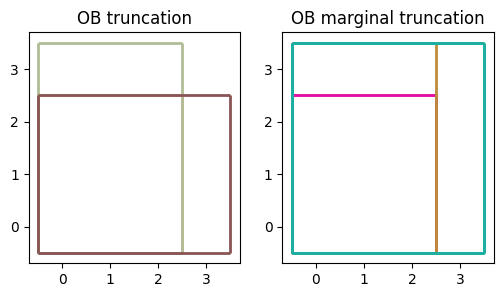

100%|██████████| 15/15 [00:00<00:00, 432.79it/s]


In [523]:
# pre-process dataset
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(count_dataset, beta)

# Optimization

## Code

### B constraints

In [36]:
def add_B_constraints(model, variables, truncation_OB, truncation_OG, i):

    # get OB truncation for sample
    min_x1_OB = truncation_OB['min_x1_OB']
    max_x1_OB = truncation_OB['max_x1_OB']
    min_x2_OB = truncation_OB['min_x2_OB']
    max_x2_OB = truncation_OB['max_x2_OB']

    # load CI bounds for sample
    bounds = np.load(f"./Test-Info/Bounds/Joint/sample-{i}.npy")
            
    # for each OB state pair in truncation
    for x1_OB in range(min_x1_OB, max_x1_OB + 1):
        for x2_OB in range(min_x2_OB, max_x2_OB + 1):

            # get OG truncation for OB state pair
            min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
            min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
            
            # load coefficient grid for OB state pair
            B_coeffs = np.load(f"./Test-Info/Coefficients/state-{x1_OB}-{x2_OB}.npy")

            # slice variables to truncation
            p1_slice = variables['p1'][min_x1_OG: max_x1_OG + 1]
            p2_slice = variables['p2'][min_x2_OG: max_x2_OG + 1]

            # bilinear form
            sum_expr = p1_slice.T @ B_coeffs @ p2_slice
        
            # form constraints using CI bounds
            model.addConstr(sum_expr >= bounds[0, x1_OB, x2_OB], name=f"B_lb_{x1_OB}_{x2_OB}")
            model.addConstr(sum_expr <= bounds[1, x1_OB, x2_OB], name=f"B_ub_{x1_OB}_{x2_OB}")

### Marginal B constraints

In [37]:
def add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG, i):

    # get marginal OB truncation for sample
    minM_x1_OB = truncationM_OB['minM_x1_OB']
    maxM_x1_OB = truncationM_OB['maxM_x1_OB']
    minM_x2_OB = truncationM_OB['minM_x2_OB']
    maxM_x2_OB = truncationM_OB['maxM_x2_OB']

    # load CI bounds for sample
    x1_bounds = np.load(f"./Test-Info/Bounds/x1_marginal/sample-{i}.npy")
    x2_bounds = np.load(f"./Test-Info/Bounds/x2_marginal/sample-{i}.npy")

    # for each OB state in truncation
    for x1_OB in range(minM_x1_OB, maxM_x1_OB + 1):

        # get OG truncation
        min_x1_OG, max_x1_OG = truncation_OG[x1_OB]

        # load marginal coefficient array for OB state
        Bm_coeffs = np.load(f"./Test-Info/Coefficients/state-{x1_OB}.npy")

        # slice variable to truncation
        p1_slice = variables['p1'][min_x1_OG: max_x1_OG + 1]

        # linear expression of sum
        sum_expr = gp.quicksum(Bm_coeffs * p1_slice)

        # form constraints using CI bounds
        model.addConstr(sum_expr >= x1_bounds[0, x1_OB], name=f"Bm_x1_lb_{x1_OB}")
        model.addConstr(sum_expr <= x1_bounds[1, x1_OB], name=f"Bm_x1_ub_{x1_OB}")

    # repeat for x2
    for x2_OB in range(minM_x2_OB, maxM_x2_OB + 1):

        # get OG truncation
        min_x2_OG, max_x2_OG = truncation_OG[x2_OB]

        # load marginal coefficient array for OB state
        Bm_coeffs = np.load(f"./Test-Info/Coefficients/state-{x2_OB}.npy")

        # slice variable to truncation
        p2_slice = variables['p2'][min_x2_OG: max_x2_OG + 1]

        # linear expression of sum
        sum_expr = gp.quicksum(Bm_coeffs * p2_slice)

        # form constraints using CI bounds
        model.addConstr(sum_expr >= x2_bounds[0, x2_OB], name=f"Bm_x2_lb_{x2_OB}")
        model.addConstr(sum_expr <= x2_bounds[1, x2_OB], name=f"Bm_x2_ub_{x2_OB}")

### Moment constraints

In [527]:
def add_moment_constraint(model, variables, extent_OG, moments_OB, beta):

    # use extent of threshold truncation for OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    E_x1 = variables['E_x1']
    E_x2 = variables['E_x2']

    # get capture efficiency moments
    E_beta = np.mean(beta)
    E_beta_sq = np.mean(beta**2)

    # expressions for moments
    expr_E_x1 = gp.quicksum(p1 * np.arange(max_x1_OG + 1))
    expr_E_x2 = gp.quicksum(p2 * np.arange(max_x2_OG + 1))

    # equate expressions
    model.addConstr(E_x1 == expr_E_x1, name="E_x1_equality")
    model.addConstr(E_x2 == expr_E_x2, name="E_x2_equality")

    # moment bounds
    model.addConstr(E_x1 <= moments_OB['E_x1'][1] / E_beta, name="E_x1_UB")
    model.addConstr(E_x1 >= moments_OB['E_x1'][0] / E_beta, name="E_x1_LB")
    model.addConstr(E_x2 <= moments_OB['E_x2'][1] / E_beta, name="E_x2_UB")
    model.addConstr(E_x2 >= moments_OB['E_x2'][0] / E_beta, name="E_x2_LB")

    # moment independence constraint
    model.addConstr(E_x1 * E_x2 <= moments_OB['E_x1_x2'][1] / E_beta_sq, name="Indep_UB")
    model.addConstr(E_x1 * E_x2 >= moments_OB['E_x1_x2'][0] / E_beta_sq, name="Indep_LB")

### CME constraints

In [39]:
def add_CME_constraints(model, variables, extent_OG):

    # get extent of OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p = variables['p']
    k_tx_1 = variables['k_tx_1']
    k_tx_2 = variables['k_tx_2']
    k_deg_1 = variables['k_deg_2']
    k_deg_2 = variables['k_deg_1']
    
    # manually add x1_OG = x2_OG = 0 constraint (to avoid p(0) terms)
    model.addConstr(
        0 == k_deg_1 * p[1, 0] + \
        k_deg_2 * p[0, 1] - \
        (k_tx_1 + k_tx_2) * p[0, 0],
        name="CME_0_0"
    )

    # manually add x1_OG = 0 constraints (to avoid p1(-1) terms)
    model.addConstrs(
        (
            0 == k_tx_2 * p[0, x2_OG - 1] + \
            k_deg_1 * p[1, x2_OG] + \
            k_deg_2 * (x2_OG + 1) * p[0, x2_OG + 1] - \
            (k_tx_1 + k_tx_2 + k_deg_2 * x2_OG) * p[0, x2_OG]
            for x2_OG in range(1, max_x2_OG)
        ),
        name="CME_0_x2"
    )
    # manually add x2_OG = 0 constraints (to avoid p2(-1) terms)
    model.addConstrs(
        (
            0 == k_tx_1 * p[x1_OG - 1, 0] + \
            k_deg_1 * (x1_OG + 1) * p[x1_OG + 1, 0] + \
            k_deg_2 * p[x1_OG, 1] - \
            (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG) * p[x1_OG, 0]
            for x1_OG in range(1, max_x1_OG)
        ),
        name="CME_x1_0"
    )

    # add CME constraints
    model.addConstrs(
        (
            0 == k_tx_1 * p[x1_OG - 1, x2_OG] + \
            k_tx_2 * p[x1_OG, x2_OG - 1] + \
            k_deg_1 * (x1_OG + 1) * p[x1_OG + 1, x2_OG] + \
            k_deg_2 * (x2_OG + 1) * p[x1_OG, x2_OG + 1] - \
            (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG + k_deg_2 * x2_OG) * p[x1_OG, x2_OG]
            for x1_OG in range(1, max_x1_OG)
            for x2_OG in range(1, max_x2_OG)
        ),
        name="CME_x1_x2"
    )

In [388]:
def add_CME_constraints_factorized(model, variables, extent_OG):

    # get extent of OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    k_tx_1 = variables['k_tx_1']
    k_tx_2 = variables['k_tx_2']
    k_deg_1 = variables['k_deg_2']
    k_deg_2 = variables['k_deg_1']

    z = model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=0, name='z')
    
    # manually add x1_OG = x2_OG = 0 constraint (to avoid p(0) terms)
    model.addConstr(
        z == k_deg_1 * p1[1] * p2[0] + \
        k_deg_2 * p1[0] * p2[1] - \
        (k_tx_1 + k_tx_2) * p1[0] * p2[0],
        name="CME_0_0"
    )

    # manually add x1_OG = 0 constraints (to avoid p1(-1) terms)
    model.addConstrs(
        (
            z == k_tx_2 * p1[0] * p2[x2_OG - 1] + \
            k_deg_1 * p1[1] * p2[x2_OG] + \
            k_deg_2 * (x2_OG + 1) * p1[0] * p2[x2_OG + 1] - \
            (k_tx_1 + k_tx_2 + k_deg_2 * x2_OG) * p1[0] * p2[x2_OG]
            for x2_OG in range(1, max_x2_OG)
        ),
        name="CME_0_x2"
    )
    # manually add x2_OG = 0 constraints (to avoid p2(-1) terms)
    model.addConstrs(
        (
            z == k_tx_1 * p1[x1_OG - 1] * p2[0] + \
            k_deg_1 * (x1_OG + 1) * p1[x1_OG + 1] * p2[0] + \
            k_deg_2 * p1[x1_OG] * p2[1] - \
            (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG) * p1[x1_OG] * p2[0]
            for x1_OG in range(1, max_x1_OG)
        ),
        name="CME_x1_0"
    )

    # add CME constraints
    model.addConstrs(
        (
            z == k_tx_1 * p1[x1_OG - 1] * p2[x2_OG] + \
            k_tx_2 * p1[x1_OG] * p2[x2_OG - 1] + \
            k_deg_1 * (x1_OG + 1) * p1[x1_OG + 1] * p2[x2_OG] + \
            k_deg_2 * (x2_OG + 1) * p1[x1_OG] * p2[x2_OG + 1] - \
            (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG + k_deg_2 * x2_OG) * p1[x1_OG] * p2[x2_OG]
            for x1_OG in range(1, max_x1_OG)
            for x2_OG in range(1, max_x2_OG)
        ),
        name="CME_x1_x2"
    )

### Marginal CME constraints

In [40]:
def add_marginal_CME_constraints(model, variables, extent_OG):

    # get extent of OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    k_tx_1 = variables['k_tx_1']
    k_tx_2 = variables['k_tx_2']
    k_deg_1 = variables['k_deg_2']
    k_deg_2 = variables['k_deg_1']

    # construct Q matrices: 1 more column than square to add upper diagonal to last row
    Q_tx_1 = (np.diag([1 for x in range(1, max_x1_OG + 1)], -1) - np.diag([1 for x in range(max_x1_OG + 1)]))[:-1, :]
    Q_tx_2 = (np.diag([1 for x in range(1, max_x2_OG + 1)], -1) - np.diag([1 for x in range(max_x2_OG + 1)]))[:-1, :]
    Q_deg_1 = (np.diag([x for x in range(1, max_x1_OG + 1)], 1) - np.diag([x for x in range(max_x1_OG + 1)]))[:-1, :]
    Q_deg_2 = (np.diag([x for x in range(1, max_x2_OG + 1)], 1) - np.diag([x for x in range(max_x2_OG + 1)]))[:-1, :]

    # add matrix constraints
    model.addConstr(
        k_tx_1 * (Q_tx_1 @ p1) + k_deg_1 * (Q_deg_1 @ p1) == 0,
        name="Marginal_CME_x1"
    )

    model.addConstr(
        k_tx_2 * (Q_tx_2 @ p2) + k_deg_2 * (Q_deg_2 @ p2) == 0,
        name="Marginal_CME_x2"
    )

### Basic constraints

e.g. fixing rates, distribution, independence factorization

In [41]:
def add_base_constraints(model, variables):

    # fix k_deg_1 = 1, k_deg = 2 for identifiability
    model.addConstr(variables['k_deg_1'] == 1, name="Fix_k_deg_1")
    model.addConstr(variables['k_deg_2'] == 1, name="Fix_k_deg_2")

    # distributional constraints
    model.addConstr(variables['p1'].sum() <= 1, name="Dist_x1")
    model.addConstr(variables['p2'].sum() <= 1, name="Dist_x2")

In [42]:
def add_factorization_constraint(model, variables):

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    p = variables['p']

    # outer product marginals
    outer = p1[:, None] @ p2[None, :]

    # equate dummy joint variable to product of marginals: all original states
    model.addConstr(p == outer, name=f"Joint_factorize")

### Model constructions

Construct models, add variables and constraints using functions before optimizing to test feasibility

Models for probability and moment constraints

In [43]:
def construct_model_probabilities(truncation_OB, truncationM_OB, truncation_OG, extent_OG, i, silent=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # joint distribution
            p = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1, extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # collect variables
            variables = {
                'p': p,
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2']
            }

            # constraints

            # base constraints
            add_base_constraints(model, variables)

            # independence constraints
            add_factorization_constraint(model, variables)

            # B constraints
            add_B_constraints(model, variables, truncation_OB, truncation_OG, i)

            # marginal B constraints
            # add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG)

            # CME constraints
            add_CME_constraints(model, variables, extent_OG)

            # marginal CME constraints
            # add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # optimize: testing feasibility
            model.setObjective(0, GRB.MINIMIZE)
            model.optimize()
            
            # get status
            status = status_codes[model.status]

            print(f"Model is {status}")

            return status

In [44]:
def construct_model_moments(moments_OB, beta, extent_OG, silent=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # joint distribution
            p = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1, extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # moments
            E_x1 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x1")
            E_x2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x2")

            # collect variables
            variables = {
                'p': p,
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2'],
                'E_x1': E_x1,
                'E_x2': E_x2
            }

            # constraints

            # base constraints
            add_base_constraints(model, variables)

            # independence constraints
            add_factorization_constraint(model, variables)

            # moment constraint
            add_moment_constraint(model, variables, extent_OG, moments_OB, beta)

            # B constraints
            # add_B_constraints(model, variables, truncation_OB, truncation_OG, i)

            # marginal B constraints
            # add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG)

            # CME constraints
            add_CME_constraints(model, variables, extent_OG)

            # marginal CME constraints
            # add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # optimize: testing feasibility
            model.setObjective(0, GRB.MINIMIZE)
            model.optimize()
            
            # get status
            status = status_codes[model.status]

            print(f"Model is {status}")

            return status

In [45]:
def construct_model_combined(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG, i, silent=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # joint distribution
            p = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1, extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # moments
            E_x1 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x1")
            E_x2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x2")

            # collect variables
            variables = {
                'p': p,
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2'],
                'E_x1': E_x1,
                'E_x2': E_x2
            }

            # constraints

            # base constraints
            add_base_constraints(model, variables)

            # independence constraints
            add_factorization_constraint(model, variables)

            # moment constraint
            add_moment_constraint(model, variables, extent_OG, moments_OB, beta)

            # B constraints
            add_B_constraints(model, variables, truncation_OB, truncation_OG, i)

            # marginal B constraints
            # add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG)

            # CME constraints
            add_CME_constraints(model, variables, extent_OG)

            # marginal CME constraints
            # add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # optimize: testing feasibility
            model.setObjective(0, GRB.MINIMIZE)
            model.optimize()
            
            # get status
            status = status_codes[model.status]

            print(f"Model is {status}")

            return status

In [437]:
def construct_model_testing(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG, i, silent=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            model.Params.MIPFocus = 1
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # joint distribution
            # p = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1, extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # moments
            E_x1 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x1")
            E_x2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x2")

            # collect variables
            variables = {
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2'],
                'E_x1': E_x1,
                'E_x2': E_x2
            }

            # constraints

            # base constraints
            add_base_constraints(model, variables)

            # independence constraints
            # add_factorization_constraint(model, variables)

            # moment constraint
            # add_moment_constraint(model, variables, extent_OG, moments_OB, beta)

            # B constraints
            add_B_constraints(model, variables, truncation_OB, truncation_OG, i)

            # marginal B constraints
            # add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG, i)

            # CME constraints
            # add_CME_constraints(model, variables, extent_OG)
            add_CME_constraints_factorized(model, variables, extent_OG)

            # marginal CME constraints
            # add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # optimize: testing feasibility
            model.setObjective(0, GRB.MINIMIZE)
            model.optimize()
            
            # get status
            status = status_codes[model.status]

            print(f"Model is {status}")

            return status

In [439]:
i = 0
sample = f"sample-{i}"
print(sample)
construct_model_testing(truncation_OB[sample], truncationM_OB[sample], moments_OB[sample], beta, truncation_OG, extent_OG[sample], 0, silent=False, time_limit=600)

sample-0
Set parameter Username
Set parameter LicenseID to value 2616229
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Set parameter TimeLimit to value 600
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  600
MIPFocus  1

Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
Optimize a model with 4 rows, 939 columns and 934 nonzeros
Model fingerprint: 0x9b68fab9
Model has 8 quadratic constraints
Model has 216225 general nonlinear constraints (2808135 nonlinear terms)
Variable types: 939 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range 

'TIME_LIMIT'

In [435]:
truncation_OG

{0: (0, 314), 1: (1, 465)}

In [467]:
bounds = np.load("./Test-Info/Bounds/Joint/sample-17.npy")
widths = bounds[1, :, :] - bounds[0, :, :]
widths[widths == 1.0] = None
#float(np.nanmean(widths))
widths

array([[0.048025, 0.046   , 0.028025, 0.012   ,      nan,      nan],
       [0.045025, 0.039025, 0.025025, 0.015025,      nan,      nan],
       [0.031   , 0.027   , 0.018   ,      nan,      nan,      nan],
       [0.018   , 0.013025,      nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan,      nan,      nan]])

In [484]:
moments_OB['sample-11']

{'E_x1': array([0.032, 0.061]),
 'E_x2': array([0.033, 0.06 ]),
 'E_x1_x2': array([0.   , 0.007])}

In [495]:
np.mean([literal_eval(x)[0] for x in dataset.iloc[0]])

np.float64(0.021)

100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


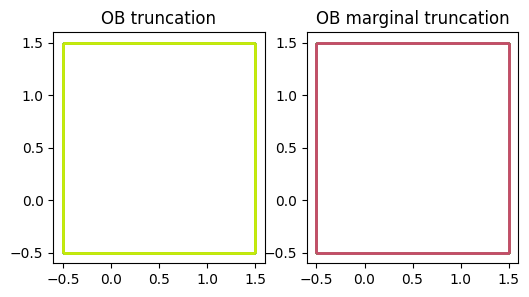

100%|██████████| 4/4 [00:00<00:00, 132.26it/s]


In [430]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_low_alt.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_low_alt.csv")

# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta, thresh_OG=10**-2)

### Dataset optimization

In [46]:
def dataset_analysis_probabilities(truncation_OB, truncationM_OB, truncation_OG, extent_OG, time_limit=300):

    # store results
    result_dict = {}

    # loop over samples in dataset
    for i, sample in enumerate(truncation_OB.keys()):

        # test feasibility
        status = construct_model_probabilities(
            truncation_OB[sample],
            truncationM_OB[sample],
            truncation_OG,
            extent_OG[sample],
            i,
            time_limit=time_limit
        )

        # record status
        result_dict[i] = status

    return result_dict

In [47]:
def dataset_analysis_moments(beta, moments_OB, extent_OG, time_limit=300):

    # store results
    result_dict = {}

    # loop over samples in dataset
    for i, sample in enumerate(truncation_OB.keys()):

        # test feasibility
        status = construct_model_moments(
            moments_OB[sample],
            beta,
            extent_OG[sample],
            time_limit=time_limit
        )

        # record status
        result_dict[i] = status

    return result_dict

In [48]:
def dataset_analysis_combined(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG, time_limit=300):

    # store results
    result_dict = {}

    # loop over samples in dataset
    for i, sample in enumerate(truncation_OB.keys()):

        # test feasibility
        status = construct_model_combined(
            truncation_OB[sample],
            truncationM_OB[sample],
            moments_OB[sample],
            beta,
            truncation_OG,
            extent_OG[sample],
            i,
            time_limit=time_limit
        )

        # record status
        result_dict[i] = status

    return result_dict

## Testing

In [158]:
prob_results = dataset_analysis_probabilities(truncation_OB, truncationM_OB, truncation_OG, extent_OG)

Model is OPTIMAL
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [ ]:
moment_results = dataset_analysis_moments(beta, moments_OB, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is OPTIMAL
Model is TIME_LIMIT
Model is TIME_LIMIT


# Correlation tests

## Code

In [79]:
def dataset_analysis_correlation(dataset, printing=True):
                
    # get dataset shape
    gene_pairs, cells = dataset.shape

    # store results
    corr_result = {}

    # loop over dataset
    for i in range(gene_pairs):

        # select sample
        sample = list(dataset.loc[f'Gene-pair-{i}'])

        # convert string to tuple if neccessary (pandas reading csv to string)
        if type(sample[0]) == str:
            sample = [literal_eval(count_pair) for count_pair in sample]

        # separate pairs into individual samples
        x1_sample = [x[0] for x in sample]
        x2_sample = [x[1] for x in sample]

        # test
        pearson = scipy.stats.pearsonr(x1_sample, x2_sample, alternative='less')

        # store result
        corr_result[i] = {'pvalue': float(pearson.pvalue), 'statistic': float(pearson.statistic)}

        if printing:
            print(f"sample {i} p-value: {pearson.pvalue}")

    return corr_result

## Testing

In [166]:
corr_results = dataset_analysis_correlation(count_dataset)

sample 0 p-value: 4.721723003002662e-08
sample 1 p-value: 1.6687679797083203e-05
sample 2 p-value: 7.870966779883357e-06
sample 3 p-value: 0.1165844749669706
sample 4 p-value: 0.0022143298818704774
sample 5 p-value: 0.006908330376833126
sample 6 p-value: 0.15576746097762842
sample 7 p-value: 0.3011104179337129
sample 8 p-value: 0.9703279324620564


# Analysis

Run analyis on simulated dataset using the different methods constructed

## Running

### High capture

In [33]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_unif_high.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_unif_high.csv")

100%|██████████| 9/9 [00:00<00:00, 11.90it/s]


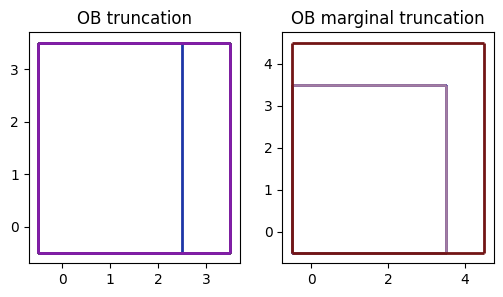

100%|██████████| 16/16 [00:00<00:00, 346.20it/s]


In [34]:
# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta)

In [35]:
# probability
prob_results = dataset_analysis_probabilities(truncation_OB, truncationM_OB, truncation_OG, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [36]:
# moment
moment_results = dataset_analysis_moments(beta, moments_OB, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [37]:
# combined
combined_results = dataset_analysis_combined(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [38]:
# correlation
corr_results = dataset_analysis_correlation(dataset)

sample 0 p-value: 3.2729801590552267e-18
sample 1 p-value: 1.1818801223547127e-13
sample 2 p-value: 5.042067307960625e-13
sample 3 p-value: 9.008611059098091e-08
sample 4 p-value: 5.486440537490913e-07
sample 5 p-value: 0.0002883880888745021
sample 6 p-value: 0.00876643676789739
sample 7 p-value: 0.02335663554498452
sample 8 p-value: 0.8278621750972538


### Medium capture

In [189]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_unif_med.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_unif_med.csv")

100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


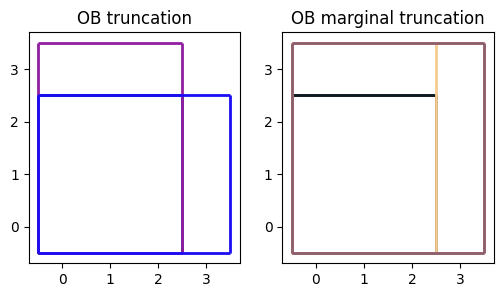

100%|██████████| 15/15 [00:00<00:00, 311.33it/s]


In [190]:
# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta)

In [173]:
# probability
prob_results = dataset_analysis_probabilities(truncation_OB, truncationM_OB, truncation_OG, extent_OG)

Model is OPTIMAL
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [174]:
# moment
moment_results = dataset_analysis_moments(beta, moments_OB, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is OPTIMAL
Model is TIME_LIMIT
Model is TIME_LIMIT


In [191]:
# combined
combined_results = dataset_analysis_combined(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [175]:
# correlation
corr_results = dataset_analysis_correlation(dataset)

sample 0 p-value: 4.721723003002662e-08
sample 1 p-value: 1.6687679797083203e-05
sample 2 p-value: 7.870966779883357e-06
sample 3 p-value: 0.1165844749669706
sample 4 p-value: 0.0022143298818704774
sample 5 p-value: 0.006908330376833126
sample 6 p-value: 0.15576746097762842
sample 7 p-value: 0.3011104179337129
sample 8 p-value: 0.9703279324620564


### Low capture

In [192]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_unif_low.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_unif_low.csv")

100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


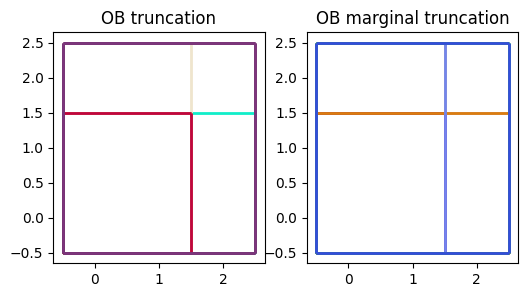

100%|██████████| 9/9 [00:00<00:00, 146.46it/s]


In [193]:
# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta)

In [181]:
# probability
prob_results = dataset_analysis_probabilities(truncation_OB, truncationM_OB, truncation_OG, extent_OG, time_limit=600)

Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT


In [195]:
# moment
moment_results = dataset_analysis_moments(beta, moments_OB, extent_OG, time_limit=600)

Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is OPTIMAL
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT


In [196]:
# combined
combined_results = dataset_analysis_combined(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG, time_limit=600)

Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT
Model is TIME_LIMIT


In [179]:
# correlation
corr_results = dataset_analysis_correlation(dataset)

sample 0 p-value: 0.0328698614367237
sample 1 p-value: 0.05603504874622022
sample 2 p-value: 0.04448852321781229
sample 3 p-value: 0.28645736537300476
sample 4 p-value: 0.6427315819539003
sample 5 p-value: 0.6221576922831449
sample 6 p-value: 0.2789604023995482
sample 7 p-value: 0.024040301556419723
sample 8 p-value: 0.4944234423041009


# Marginal Analysis

## Code

### Marginal model constructions

In [559]:
def construct_model_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG, i, silent=True, time_limit=300, printing=True):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # collect variables
            variables = {
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2']
            }

            # constraints

            # base constraints
            add_base_constraints(model, variables)

            # marginal B constraints
            add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG, i)

            # marginal CME constraints
            add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # optimize: testing feasibility
            model.setObjective(0, GRB.MINIMIZE)

            try:
                model.optimize()
            except gp.GurobiError:
                print("GurobiError")
                return None
            
            # get status
            status = status_codes[model.status]

            if printing:
                print(f"Model is {status}")

            return status

In [619]:
def construct_model_moments_marginal(moments_OB, beta, extent_OG, silent=True, time_limit=300, printing=True):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # moments
            E_x1 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x1")
            E_x2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x2")

            # collect variables
            variables = {
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2'],
                'E_x1': E_x1,
                'E_x2': E_x2
            }

            # constraints

            # base constraints
            add_base_constraints(model, variables)

            # moment constraint
            add_moment_constraint(model, variables, extent_OG, moments_OB, beta)

            # marginal CME constraints
            add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # optimize: testing feasibility
            model.setObjective(0, GRB.MINIMIZE)
            
            try:
                model.optimize()
            except gp.GurobiError:
                print("GurobiError")
                return None
            
            # get status
            status = status_codes[model.status]

            if printing:
                print(f"Model is {status}")

            return status

In [561]:
def construct_model_combined_marginal(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG, i, silent=True, time_limit=300, printing=True):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # moments
            E_x1 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x1")
            E_x2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x2")

            # collect variables
            variables = {
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2'],
                'E_x1': E_x1,
                'E_x2': E_x2
            }

            # constraints

            # base constraints
            add_base_constraints(model, variables)

            # moment constraint
            add_moment_constraint(model, variables, extent_OG, moments_OB, beta)

            # marginal B constraints
            add_marginal_B_constraints(model, variables, truncationM_OB, truncation_OG, i)

            # marginal CME constraints
            add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # optimize: testing feasibility
            model.setObjective(0, GRB.MINIMIZE)
            
            try:
                model.optimize()
            except gp.GurobiError:
                print(f"GurobiError")
                return None
            
            # get status
            status = status_codes[model.status]

            if printing:
                print(f"Model is {status}")

            return status

### Marginal dataset optimization

In [75]:
def dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG, time_limit=300, printing=True):

    # store results
    result_dict = {}

    # loop over samples in dataset
    for i, sample in enumerate(truncation_OB.keys()):

        # test feasibility
        status = construct_model_probabilities_marginal(
            truncation_OB[sample],
            truncationM_OB[sample],
            truncation_OG,
            extent_OG[sample],
            i,
            time_limit=time_limit,
            printing=printing
        )

        # record status
        result_dict[i] = status

    return result_dict

In [654]:
def dataset_analysis_moments_marginal(beta, moments_OB, extent_OG, time_limit=300, printing=True, scaling_truncation=False):

    # store results
    result_dict = {}

    # loop over samples in dataset
    for i, sample in enumerate(moments_OB.keys()):

        # truncation type
        if scaling_truncation:
            sample_extent = moments_OB[sample]
        else:
            sample_extent = extent_OG[sample]

        # test feasibility
        status = construct_model_moments_marginal(
            moments_OB[sample],
            beta,
            sample_extent,
            time_limit=time_limit,
            printing=printing
        )

        # record status
        result_dict[i] = status

    return result_dict

In [78]:
def dataset_analysis_combined_marginal(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG, time_limit=300, printing=True):

    # store results
    result_dict = {}

    # loop over samples in dataset
    for i, sample in enumerate(truncation_OB.keys()):

        # test feasibility
        status = construct_model_combined_marginal(
            truncation_OB[sample],
            truncationM_OB[sample],
            moments_OB[sample],
            beta,
            truncation_OG,
            extent_OG[sample],
            i,
            time_limit=time_limit,
            printing=printing
        )

        # record status
        result_dict[i] = status

    return result_dict

## Running

### High capture

In [45]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_unif_high.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_unif_high.csv")

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 13.94it/s]


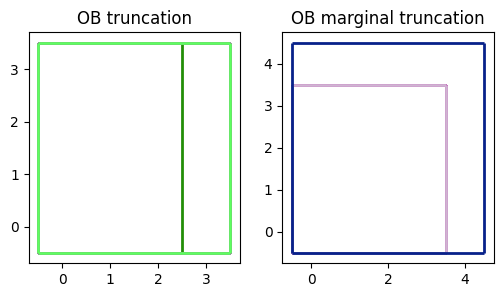

100%|██████████| 16/16 [00:00<00:00, 2291.42it/s]


In [54]:
# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta)

In [55]:
# probability (marginal)
prob_results = dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is INFEASIBLE


In [56]:
# moment (marginal)
moment_results = dataset_analysis_moments_marginal(beta, moments_OB, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [57]:
# combined (marginal)
combined_results = dataset_analysis_combined_marginal(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is INFEASIBLE


In [58]:
# correlation (reference)
corr_results = dataset_analysis_correlation(dataset)

sample 0 p-value: 3.2729801590552267e-18
sample 1 p-value: 1.1818801223547127e-13
sample 2 p-value: 5.042067307960625e-13
sample 3 p-value: 9.008611059098091e-08
sample 4 p-value: 5.486440537490913e-07
sample 5 p-value: 0.0002883880888745021
sample 6 p-value: 0.00876643676789739
sample 7 p-value: 0.02335663554498452
sample 8 p-value: 0.8278621750972538


### Medium capture

In [59]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_unif_med.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_unif_med.csv")

100%|██████████| 9/9 [00:00<00:00, 14.43it/s]


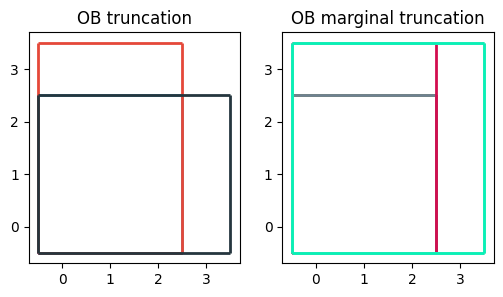

100%|██████████| 15/15 [00:00<00:00, 544.68it/s]


In [60]:
# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta)

In [61]:
# probability (marginal)
prob_results = dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG)

Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [62]:
# moment (marginal)
moment_results = dataset_analysis_moments_marginal(beta, moments_OB, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [63]:
# combined (marginal)
combined_results = dataset_analysis_combined_marginal(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [64]:
# correlation (reference)
corr_results = dataset_analysis_correlation(dataset)

sample 0 p-value: 4.721723003002662e-08
sample 1 p-value: 1.6687679797083203e-05
sample 2 p-value: 7.870966779883357e-06
sample 3 p-value: 0.1165844749669706
sample 4 p-value: 0.0022143298818704774
sample 5 p-value: 0.006908330376833126
sample 6 p-value: 0.15576746097762842
sample 7 p-value: 0.3011104179337129
sample 8 p-value: 0.9703279324620564


### Low capture

In [336]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_unif_low.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_unif_low.csv")

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00,  9.16it/s]


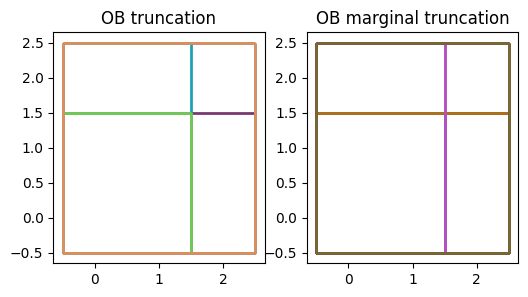

100%|██████████| 9/9 [00:00<00:00, 240.17it/s]


In [337]:
# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta)

In [338]:
# probability (marginal)
prob_results = dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG)

Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [339]:
# moment (marginal)
moment_results = dataset_analysis_moments_marginal(beta, moments_OB, extent_OG)

Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [69]:
# combined (marginal)
combined_results = dataset_analysis_combined_marginal(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG)

Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [340]:
# correlation (reference)
corr_results = dataset_analysis_correlation(dataset)

sample 0 p-value: 0.0328698614367237
sample 1 p-value: 0.05603504874622022
sample 2 p-value: 0.04448852321781229
sample 3 p-value: 0.28645736537300476
sample 4 p-value: 0.6427315819539003
sample 5 p-value: 0.6221576922831449
sample 6 p-value: 0.2789604023995482
sample 7 p-value: 0.024040301556419723
sample 8 p-value: 0.4944234423041009


### Alternate dataset low capture

In [423]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_low_alt.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_low_alt.csv")

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:01<00:00, 11.35it/s]


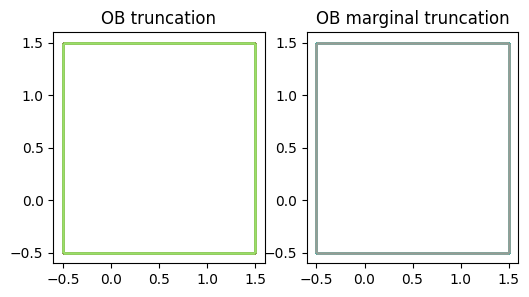

100%|██████████| 4/4 [00:00<00:00, 18.42it/s]


In [427]:
# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta, thresh_OG=10**-6)

In [300]:
# probability (marginal)
prob_results = dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG)

Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [301]:
# moment (marginal)
moment_results = dataset_analysis_moments_marginal(beta, moments_OB, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [302]:
# combined (marginal)
combined_results = dataset_analysis_combined_marginal(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG)

Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [303]:
# correlation (reference)
corr_results = dataset_analysis_correlation(dataset)

sample 0 p-value: 0.26449888093586177
sample 1 p-value: 0.26762285392254664
sample 2 p-value: 0.21247935322211925
sample 3 p-value: 0.23799174379775423
sample 4 p-value: 0.3037514044261847
sample 5 p-value: 0.2001234579374933
sample 6 p-value: 0.17897669033309943
sample 7 p-value: 0.8041967685422511
sample 8 p-value: 0.5831429730450568
sample 9 p-value: 0.46375481320585066
sample 10 p-value: 0.6765949446518016
sample 11 p-value: 0.7060183272528844
sample 12 p-value: 0.9882742023003069
sample 13 p-value: 0.9679805868189557


In [306]:
pd.read_csv("./Test-Info/Data/params_alt.csv", index_col="Unnamed: 0")['k_reg']

Gene-pair-0     50.0
Gene-pair-1     20.0
Gene-pair-2     10.0
Gene-pair-3      8.0
Gene-pair-4      6.0
Gene-pair-5      4.0
Gene-pair-6      2.0
Gene-pair-7      1.0
Gene-pair-8      0.8
Gene-pair-9      0.6
Gene-pair-10     0.4
Gene-pair-11     0.2
Gene-pair-12     0.1
Gene-pair-13     0.0
Name: k_reg, dtype: float64

### Focused on [1, 2] int str range

In [319]:
# load
dataset = pd.read_csv("./Test-Info/Data/counts_low_focus.csv", index_col=0)
beta = np.loadtxt("./Test-Info/Data/beta_low_focus.csv")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


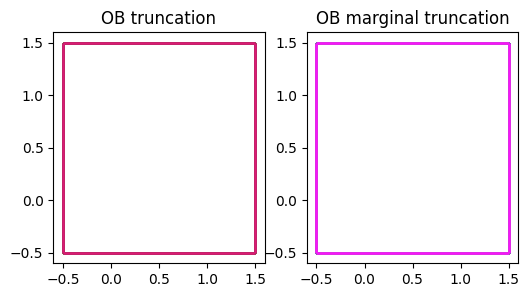

100%|██████████| 4/4 [00:00<00:00, 12.85it/s]


In [320]:
# process
truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(dataset, beta)

In [323]:
# probability (marginal)
prob_results = dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG)

Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL


In [324]:
# moment (marginal)
moment_results = dataset_analysis_moments_marginal(beta, moments_OB, extent_OG)

Model is OPTIMAL
Model is OPTIMAL
Model is INFEASIBLE
Model is OPTIMAL
Model is INFEASIBLE
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is OPTIMAL
Model is INFEASIBLE


In [ ]:
# combined (marginal)
combined_results = dataset_analysis_combined_marginal(truncation_OB, truncationM_OB, moments_OB, beta, truncation_OG, extent_OG)

In [316]:
# correlation (reference)
corr_results = dataset_analysis_correlation(dataset)

sample 0 p-value: 0.26449888093586177
sample 1 p-value: 0.26762285392254664
sample 2 p-value: 0.21247935322211925
sample 3 p-value: 0.23799174379775423
sample 4 p-value: 0.3037514044261847
sample 5 p-value: 0.2001234579374933
sample 6 p-value: 0.17897669033309943
sample 7 p-value: 0.8041967685422511
sample 8 p-value: 0.5831429730450568
sample 9 p-value: 0.46375481320585066
sample 10 p-value: 0.6765949446518016
sample 11 p-value: 0.7060183272528844
sample 12 p-value: 0.9882742023003069
sample 13 p-value: 0.9679805868189557


In [321]:
pd.read_csv("./Test-Info/Data/params_focus.csv", index_col="Unnamed: 0")['k_reg']

Gene-pair-0    2.6
Gene-pair-1    2.4
Gene-pair-2    2.2
Gene-pair-3    2.0
Gene-pair-4    1.8
Gene-pair-5    1.6
Gene-pair-6    1.4
Gene-pair-7    1.2
Gene-pair-8    1.0
Gene-pair-9    0.8
Name: k_reg, dtype: float64

# Gridtest: capture mean vs spread

Following the investigation in "Realistic-Data/Sampled-Capture-Data/capture_correlation_gridtest" want to investigate how the performance of optimization methods is affected by the mean and spread of the per cell capture efficiency distribution.

To investigate:

- Simulate a dataset of samples with a range of interaction strengths
- produce capture efficincy vectors over a grid of mean x spread
- downsample dataset using each capture efficiency
- analyse each dataset using optimizations
- display results

## Test: Normal capture distribution

In [202]:
# gridtest ranges
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.8, 0.6, 0.4, 0.2, 0]
mean_values = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.0]
width_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [127]:
# simulate original dataset
datasets = simulate_dataset(
    cells = 1000,
    interaction_values = interaction_values
)

100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


In [128]:
# store data
data_dict = {}

# grid of capture efficiencies
for mean in mean_values:
    for width in width_values:

        # store
        info_dict = {}

        # sample
        # beta = rng.uniform(mean - width, mean + width, size=1000)
        beta = rng.normal(mean, width, size=1000)

        # clamp to [0, 1]
        beta[beta > 1.0] = 1.0
        beta[beta < 0.1] = 0.1
        '''thresholding above 10%'''

        # store
        info_dict['beta'] = beta

        # downsample dataset
        counts_downsampled = simulate_downsampled_dataset(datasets['counts_df'], beta)

        # store
        info_dict['counts_df'] = counts_downsampled

        # store
        data_dict[(mean, width)] = info_dict

In [ ]:
# grid of capture efficiencies and datasets
ct = 1
for capture, data in data_dict.items():

    # counter
    print(f"{ct} / {len(data_dict)}")
    ct += 1

    # process dataset
    truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(data['counts_df'], data['beta'], display=False)

    # analyse dataset
    corr_results = dataset_analysis_correlation(data['counts_df'], printing=False)
    prob_results = dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG, printing=False)
    momt_results = dataset_analysis_moments_marginal(data['beta'], moments_OB, extent_OG, printing=False)
    comb_results = dataset_analysis_combined_marginal(truncation_OB, truncationM_OB, moments_OB, data['beta'], truncation_OG, extent_OG, printing=False)

    # store
    data_dict[capture]['corr'] = corr_results
    data_dict[capture]['prob'] = prob_results
    data_dict[capture]['momt'] = momt_results
    data_dict[capture]['comb'] = comb_results

1 / 42


100%|██████████| 20/20 [00:00<00:00, 339.69it/s]


2 / 42


100%|██████████| 16/16 [00:00<00:00, 412.82it/s]


3 / 42


100%|██████████| 16/16 [00:00<00:00, 181.16it/s]


4 / 42


100%|██████████| 16/16 [00:00<00:00, 173.26it/s]


5 / 42


100%|██████████| 16/16 [00:00<00:00, 170.15it/s]


6 / 42


100%|██████████| 16/16 [00:00<00:00, 126.83it/s]


7 / 42


100%|██████████| 16/16 [00:00<00:00, 412.71it/s]


8 / 42


100%|██████████| 16/16 [00:00<00:00, 266.25it/s]


9 / 42


100%|██████████| 16/16 [00:00<00:00, 215.65it/s]


10 / 42


100%|██████████| 16/16 [00:00<00:00, 174.82it/s]


11 / 42


100%|██████████| 16/16 [00:00<00:00, 185.62it/s]


12 / 42


100%|██████████| 16/16 [00:00<00:00, 164.48it/s]


13 / 42


100%|██████████| 15/15 [00:00<00:00, 380.50it/s]


14 / 42


100%|██████████| 16/16 [00:00<00:00, 242.66it/s]


15 / 42


100%|██████████| 16/16 [00:00<00:00, 179.89it/s]


16 / 42


100%|██████████| 16/16 [00:00<00:00, 153.56it/s]


17 / 42


100%|██████████| 16/16 [00:00<00:00, 150.21it/s]


18 / 42


100%|██████████| 16/16 [00:00<00:00, 191.31it/s]


19 / 42


100%|██████████| 9/9 [00:00<00:00, 425.31it/s]


20 / 42


100%|██████████| 9/9 [00:00<00:00, 201.67it/s]


21 / 42


100%|██████████| 9/9 [00:00<00:00, 180.98it/s]


22 / 42


100%|██████████| 12/12 [00:00<00:00, 161.89it/s]


23 / 42


100%|██████████| 16/16 [00:00<00:00, 173.36it/s]


24 / 42


100%|██████████| 16/16 [00:00<00:00, 136.21it/s]


25 / 42


100%|██████████| 9/9 [00:00<00:00, 362.64it/s]


26 / 42


100%|██████████| 9/9 [00:00<00:00, 192.22it/s]


27 / 42


100%|██████████| 9/9 [00:00<00:00, 174.47it/s]


28 / 42


100%|██████████| 9/9 [00:00<00:00, 179.81it/s]


29 / 42


100%|██████████| 9/9 [00:00<00:00, 153.77it/s]


30 / 42


100%|██████████| 15/15 [00:00<00:00, 167.50it/s]


31 / 42


100%|██████████| 4/4 [00:00<00:00, 329.63it/s]


32 / 42


100%|██████████| 9/9 [00:00<00:00, 212.56it/s]


33 / 42


100%|██████████| 9/9 [00:00<00:00, 184.81it/s]


34 / 42


100%|██████████| 9/9 [00:00<00:00, 174.13it/s]


35 / 42


100%|██████████| 9/9 [00:00<00:00, 161.01it/s]


36 / 42


100%|██████████| 9/9 [00:00<00:00, 168.66it/s]


37 / 42


100%|██████████| 4/4 [00:00<00:00, 242.15it/s]


38 / 42


100%|██████████| 6/6 [00:00<00:00, 191.49it/s]


39 / 42


100%|██████████| 9/9 [00:00<00:00, 207.64it/s]


40 / 42


100%|██████████| 9/9 [00:00<00:00, 153.80it/s]


41 / 42


100%|██████████| 9/9 [00:00<00:00, 167.53it/s]


42 / 42


100%|██████████| 12/12 [00:00<00:00, 180.98it/s]


In [274]:
for capture, data in data_dict.items():

    # get results
    corr_results = data_dict[capture]['corr']
    prob_results = data_dict[capture]['prob']
    momt_results = data_dict[capture]['momt']
    comb_results = data_dict[capture]['comb']

    # smallest interaction strength detected
    min_corr = interaction_values[0] + 1
    min_prob = interaction_values[0] + 1
    min_momt = interaction_values[0] + 1
    min_comb = interaction_values[0] + 1
    for i in corr_results.keys():
        if corr_results[i]['pvalue'] < 0.05 and (interaction_values[i] < min_corr):
            min_corr = interaction_values[i]
        if prob_results[i] == "INFEASIBLE" and (interaction_values[i] < min_prob):
            min_prob = interaction_values[i]
        if momt_results[i] == "INFEASIBLE" and (interaction_values[i] < min_momt):
            min_momt = interaction_values[i]
        if comb_results[i] == "INFEASIBLE" and (interaction_values[i] < min_comb):
            min_comb = interaction_values[i]

    # if 0 (false positive): set to non-zero value for log
    if min_corr == 0.0:
        min_corr = interaction_values[-2] / 2
    if min_prob == 0.0:
        min_prob = interaction_values[-2] / 2
    if min_momt == 0.0:
        min_momt = interaction_values[-2] / 2
    if min_comb == 0.0:
        min_comb = interaction_values[-2] / 2

    data_dict[capture]['min_corr'] = min_corr
    data_dict[capture]['min_prob'] = min_prob
    data_dict[capture]['min_momt'] = min_momt
    data_dict[capture]['min_comb'] = min_comb

    # largest iteraction strength not detected
    max_corr = None
    max_prob = None
    max_momt = None
    max_comb = None
    for i in corr_results.keys():
        if corr_results[i]['pvalue'] > 0.05 and (max_corr is None):
            max_corr = interaction_values[i]
        if prob_results[i] == "OPTIMAL" and (max_prob is None):
            max_prob = interaction_values[i]
        if momt_results[i] == "OPTIMAL" and (max_momt is None):
            max_momt = interaction_values[i]
        if comb_results[i] == "OPTIMAL" and (max_comb is None):
            max_comb = interaction_values[i]

    if max_corr is None:
        max_corr = interaction_values[-2] / 2
    if max_prob is None:
        max_prob = interaction_values[-2] / 2
    if max_momt is None:
        max_momt = interaction_values[-2] / 2
    if max_comb is None:
        max_comb = interaction_values[-2] / 2

    data_dict[capture]['max_corr'] = max_corr
    data_dict[capture]['max_prob'] = max_prob
    data_dict[capture]['max_momt'] = max_momt
    data_dict[capture]['max_comb'] = max_comb

In [277]:
# extract threshold info into plottable grid
corr_array = np.zeros((len(mean_values), len(width_values)))
prob_array = np.zeros((len(mean_values), len(width_values)))
momt_array = np.zeros((len(mean_values), len(width_values)))
comb_array = np.zeros((len(mean_values), len(width_values)))
for i, mean in enumerate(mean_values):
    for j, width in enumerate(width_values):
        corr_array[i, j] = data_dict[(mean, width)]['min_corr']
        prob_array[i, j] = data_dict[(mean, width)]['min_prob']
        momt_array[i, j] = data_dict[(mean, width)]['min_momt']
        comb_array[i, j] = data_dict[(mean, width)]['min_comb']

vmin, vmax = interaction_values[-2], interaction_values[0]

In [279]:
corr_array = np.log10(corr_array)
prob_array = np.log10(prob_array)
momt_array = np.log10(momt_array)
comb_array = np.log10(comb_array)
vmin, vmax = np.log10(interaction_values[-2]), np.log10(interaction_values[0])

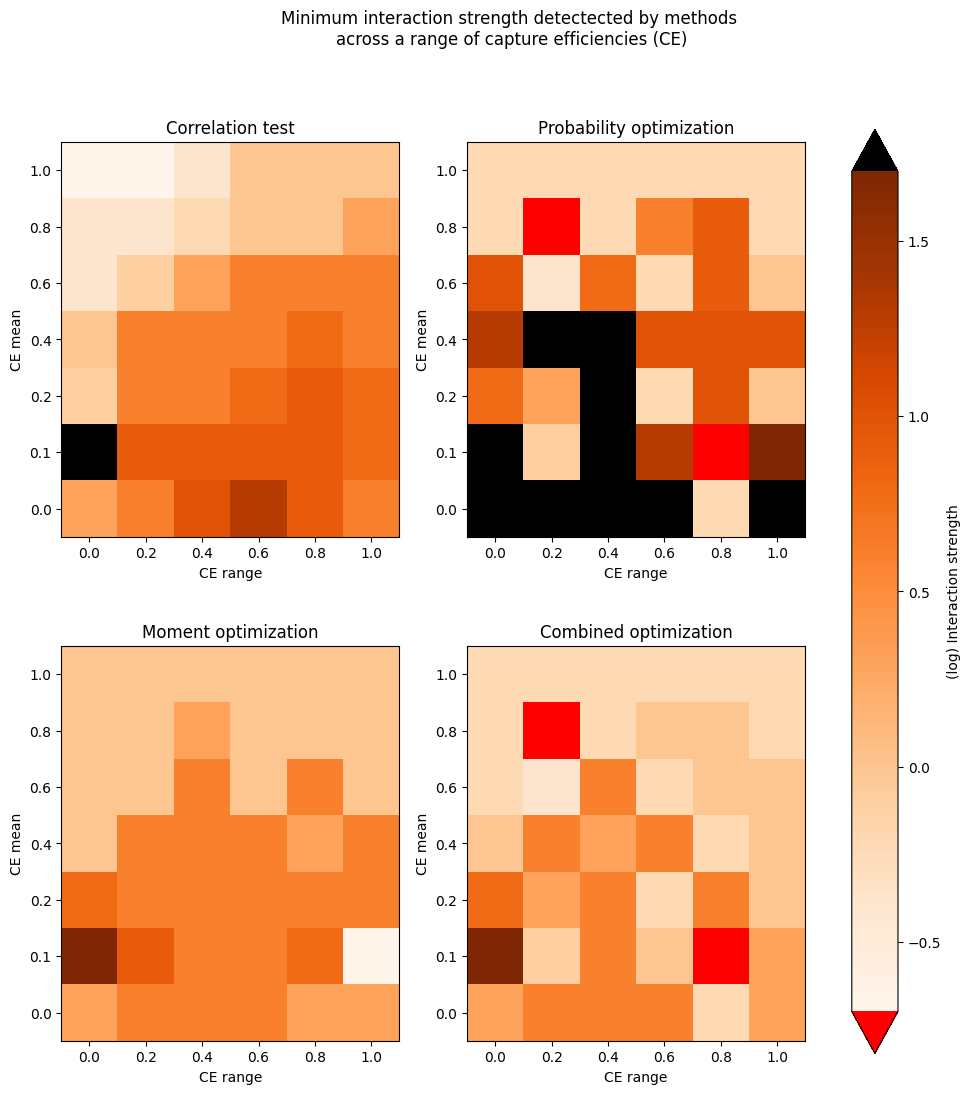

In [280]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# correlation
img_corr = axs[0, 0].imshow(corr_array, cmap='Oranges', vmin=vmin, vmax=vmax)
axs[0, 0].set_xlabel("CE range")
axs[0, 0].set_xticks(range(len(width_values)))
axs[0, 0].set_xticklabels(width_values)
axs[0, 0].set_ylabel("CE mean")
axs[0, 0].set_yticks(range(len(mean_values)))
axs[0, 0].set_yticklabels(mean_values)
axs[0, 0].set_title("Correlation test")

# probability
img_prob = axs[0, 1].imshow(prob_array, cmap='Oranges', vmin=vmin, vmax=vmax)
axs[0, 1].set_xlabel("CE range")
axs[0, 1].set_xticks(range(len(width_values)))
axs[0, 1].set_xticklabels(width_values)
axs[0, 1].set_ylabel("CE mean")
axs[0, 1].set_yticks(range(len(mean_values)))
axs[0, 1].set_yticklabels(mean_values)
axs[0, 1].set_title("Probability optimization")

# moments
img_momt = axs[1, 0].imshow(momt_array, cmap='Oranges', vmin=vmin, vmax=vmax)
axs[1, 0].set_xlabel("CE range")
axs[1, 0].set_xticks(range(len(width_values)))
axs[1, 0].set_xticklabels(width_values)
axs[1, 0].set_ylabel("CE mean")
axs[1, 0].set_yticks(range(len(mean_values)))
axs[1, 0].set_yticklabels(mean_values)
axs[1, 0].set_title("Moment optimization")

# combined
img_comb = axs[1, 1].imshow(comb_array, cmap='Oranges', vmin=vmin, vmax=vmax)
axs[1, 1].set_xlabel("CE range")
axs[1, 1].set_xticks(range(len(width_values)))
axs[1, 1].set_xticklabels(width_values)
axs[1, 1].set_ylabel("CE mean")
axs[1, 1].set_yticks(range(len(mean_values)))
axs[1, 1].set_yticklabels(mean_values)
axs[1, 1].set_title("Combined optimization")

fig.suptitle("Minimum interaction strength detectected by methods \nacross a range of capture efficiencies (CE)")

cbar = plt.colorbar(img_corr, ax=axs[0, 0], extend="both")
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.remove()
cbar = plt.colorbar(img_prob, ax=axs[0, 1], extend="both")
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.remove()
cbar = plt.colorbar(img_momt, ax=axs[1, 0], extend="both")
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.remove()
cbar = plt.colorbar(img_comb, ax=axs[1, 1], extend="both")
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.remove()

cbar = plt.colorbar(img_prob, ax=axs, extend="both", )
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.set_label("(log) Interaction strength")

Moment optimiztion appears to perform very well, better than correlation test performance for lower mean capture

## Test: Uniform capture distribution

In [325]:
# gridtest ranges
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.8, 0.6, 0.4, 0.2, 0]
mean_values = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.0]
width_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [326]:
# simulate original dataset
datasets = simulate_dataset(
    cells = 1000,
    interaction_values = interaction_values
)

100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


In [327]:
# store data
data_dict = {}

# grid of capture efficiencies
for mean in mean_values:
    for width in width_values:

        # store
        info_dict = {}

        # sample
        beta = rng.uniform(mean - (width / 2), mean + (width / 2), size=1000)
        # beta = rng.normal(mean, width, size=1000)

        # clamp to [0, 1]
        beta[beta > 1.0] = 1.0
        beta[beta < 0.1] = 0.1
        '''thresholding above 10%'''

        # store
        info_dict['beta'] = beta

        # downsample dataset
        counts_downsampled = simulate_downsampled_dataset(datasets['counts_df'], beta)

        # store
        info_dict['counts_df'] = counts_downsampled

        # store
        data_dict[(mean, width)] = info_dict

In [328]:
# grid of capture efficiencies and datasets
ct = 1
for capture, data in data_dict.items():

    # counter
    print(f"{ct} / {len(data_dict)}")
    ct += 1

    # process dataset
    truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(data['counts_df'], data['beta'], display=False)

    # analyse dataset
    corr_results = dataset_analysis_correlation(data['counts_df'], printing=False)
    prob_results = dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG, printing=False)
    momt_results = dataset_analysis_moments_marginal(data['beta'], moments_OB, extent_OG, printing=False)
    comb_results = dataset_analysis_combined_marginal(truncation_OB, truncationM_OB, moments_OB, data['beta'], truncation_OG, extent_OG, printing=False)

    # store
    data_dict[capture]['corr'] = corr_results
    data_dict[capture]['prob'] = prob_results
    data_dict[capture]['momt'] = momt_results
    data_dict[capture]['comb'] = comb_results

1 / 42


100%|██████████| 16/16 [00:00<00:00, 360.09it/s]


2 / 42


100%|██████████| 16/16 [00:00<00:00, 582.03it/s]


3 / 42


100%|██████████| 16/16 [00:00<00:00, 558.19it/s]


4 / 42


100%|██████████| 16/16 [00:00<00:00, 558.31it/s]


5 / 42


100%|██████████| 16/16 [00:00<00:00, 802.46it/s]


6 / 42


100%|██████████| 16/16 [00:00<00:00, 900.71it/s]


7 / 42


100%|██████████| 16/16 [00:00<00:00, 665.91it/s]


8 / 42


100%|██████████| 16/16 [00:00<00:00, 909.74it/s]


9 / 42


100%|██████████| 16/16 [00:00<00:00, 521.15it/s]


10 / 42


100%|██████████| 16/16 [00:00<00:00, 516.52it/s]


11 / 42


100%|██████████| 16/16 [00:00<00:00, 505.63it/s]


12 / 42


100%|██████████| 16/16 [00:00<00:00, 390.33it/s]


13 / 42


100%|██████████| 16/16 [00:00<00:00, 657.44it/s]


14 / 42


100%|██████████| 16/16 [00:00<00:00, 554.67it/s]


15 / 42


100%|██████████| 16/16 [00:00<00:00, 582.59it/s]


16 / 42


100%|██████████| 16/16 [00:00<00:00, 539.66it/s]


17 / 42


100%|██████████| 16/16 [00:00<00:00, 318.97it/s]


18 / 42


100%|██████████| 16/16 [00:00<00:00, 329.61it/s]


19 / 42


100%|██████████| 9/9 [00:00<00:00, 548.05it/s]


20 / 42


100%|██████████| 9/9 [00:00<00:00, 529.85it/s]


21 / 42


100%|██████████| 9/9 [00:00<00:00, 396.47it/s]


22 / 42


100%|██████████| 12/12 [00:00<00:00, 370.31it/s]


23 / 42


100%|██████████| 12/12 [00:00<00:00, 250.13it/s]


24 / 42


100%|██████████| 9/9 [00:00<00:00, 348.99it/s]


25 / 42


100%|██████████| 9/9 [00:00<00:00, 357.53it/s]


26 / 42


100%|██████████| 8/8 [00:00<00:00, 374.66it/s]


27 / 42


100%|██████████| 9/9 [00:00<00:00, 358.78it/s]


28 / 42


100%|██████████| 9/9 [00:00<00:00, 349.27it/s]


29 / 42


100%|██████████| 9/9 [00:00<00:00, 341.67it/s]


30 / 42


100%|██████████| 9/9 [00:00<00:00, 332.20it/s]


31 / 42


100%|██████████| 4/4 [00:00<00:00, 199.85it/s]


32 / 42


100%|██████████| 6/6 [00:00<00:00, 225.94it/s]


33 / 42


100%|██████████| 9/9 [00:00<00:00, 374.02it/s]


34 / 42


100%|██████████| 9/9 [00:00<00:00, 375.91it/s]


35 / 42


100%|██████████| 9/9 [00:00<00:00, 342.42it/s]


36 / 42


100%|██████████| 9/9 [00:00<00:00, 347.05it/s]


37 / 42


100%|██████████| 4/4 [00:00<00:00, 306.25it/s]


38 / 42


100%|██████████| 4/4 [00:00<00:00, 404.62it/s]


39 / 42


100%|██████████| 4/4 [00:00<00:00, 414.38it/s]


40 / 42


100%|██████████| 6/6 [00:00<00:00, 263.77it/s]


41 / 42


100%|██████████| 9/9 [00:00<00:00, 540.97it/s]


42 / 42


100%|██████████| 9/9 [00:00<00:00, 346.94it/s]


In [329]:
for capture, data in data_dict.items():

    # get results
    corr_results = data_dict[capture]['corr']
    prob_results = data_dict[capture]['prob']
    momt_results = data_dict[capture]['momt']
    comb_results = data_dict[capture]['comb']

    # smallest interaction strength detected
    min_corr = interaction_values[0] + 1
    min_prob = interaction_values[0] + 1
    min_momt = interaction_values[0] + 1
    min_comb = interaction_values[0] + 1
    for i in corr_results.keys():
        if corr_results[i]['pvalue'] < 0.05 and (interaction_values[i] < min_corr):
            min_corr = interaction_values[i]
        if prob_results[i] == "INFEASIBLE" and (interaction_values[i] < min_prob):
            min_prob = interaction_values[i]
        if momt_results[i] == "INFEASIBLE" and (interaction_values[i] < min_momt):
            min_momt = interaction_values[i]
        if comb_results[i] == "INFEASIBLE" and (interaction_values[i] < min_comb):
            min_comb = interaction_values[i]

    # if 0 (false positive): set to non-zero value for log
    if min_corr == 0.0:
        min_corr = interaction_values[-2] / 2
    if min_prob == 0.0:
        min_prob = interaction_values[-2] / 2
    if min_momt == 0.0:
        min_momt = interaction_values[-2] / 2
    if min_comb == 0.0:
        min_comb = interaction_values[-2] / 2

    data_dict[capture]['min_corr'] = min_corr
    data_dict[capture]['min_prob'] = min_prob
    data_dict[capture]['min_momt'] = min_momt
    data_dict[capture]['min_comb'] = min_comb

    # largest iteraction strength not detected
    max_corr = None
    max_prob = None
    max_momt = None
    max_comb = None
    for i in corr_results.keys():
        if corr_results[i]['pvalue'] > 0.05 and (max_corr is None):
            max_corr = interaction_values[i]
        if prob_results[i] == "OPTIMAL" and (max_prob is None):
            max_prob = interaction_values[i]
        if momt_results[i] == "OPTIMAL" and (max_momt is None):
            max_momt = interaction_values[i]
        if comb_results[i] == "OPTIMAL" and (max_comb is None):
            max_comb = interaction_values[i]

    if max_corr is None:
        max_corr = interaction_values[-2] / 2
    if max_prob is None:
        max_prob = interaction_values[-2] / 2
    if max_momt is None:
        max_momt = interaction_values[-2] / 2
    if max_comb is None:
        max_comb = interaction_values[-2] / 2

    data_dict[capture]['max_corr'] = max_corr
    data_dict[capture]['max_prob'] = max_prob
    data_dict[capture]['max_momt'] = max_momt
    data_dict[capture]['max_comb'] = max_comb

In [334]:
# extract threshold info into plottable grid
corr_array = np.zeros((len(mean_values), len(width_values)))
prob_array = np.zeros((len(mean_values), len(width_values)))
momt_array = np.zeros((len(mean_values), len(width_values)))
comb_array = np.zeros((len(mean_values), len(width_values)))
for i, mean in enumerate(mean_values):
    for j, width in enumerate(width_values):
        corr_array[i, j] = data_dict[(mean, width)]['min_corr']
        prob_array[i, j] = data_dict[(mean, width)]['min_prob']
        momt_array[i, j] = data_dict[(mean, width)]['min_momt']
        comb_array[i, j] = data_dict[(mean, width)]['min_comb']

vmin, vmax = interaction_values[-2], interaction_values[0]

In [332]:
corr_array = np.log10(corr_array)
prob_array = np.log10(prob_array)
momt_array = np.log10(momt_array)
comb_array = np.log10(comb_array)
vmin, vmax = np.log10(interaction_values[-2]), np.log10(interaction_values[0])

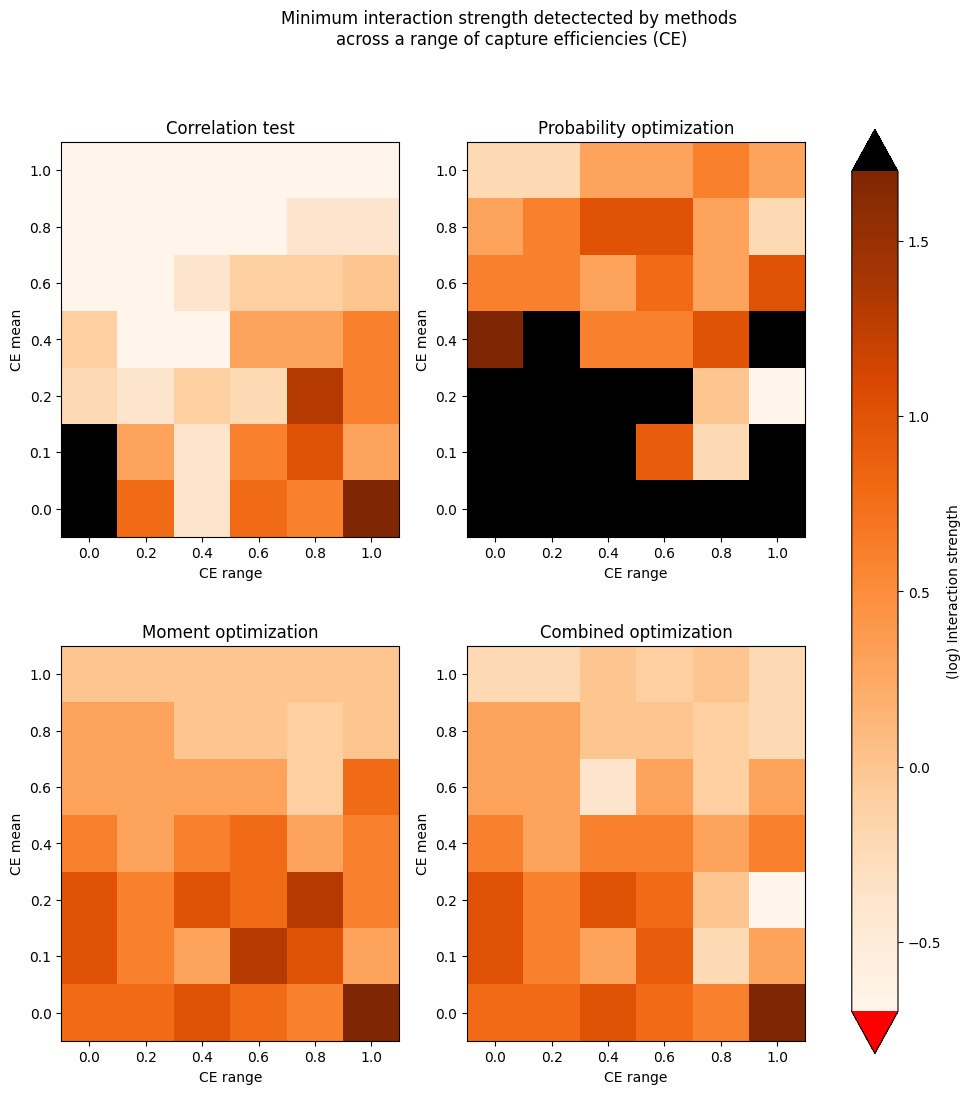

In [333]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# correlation
img_corr = axs[0, 0].imshow(corr_array, cmap='Oranges', vmin=vmin, vmax=vmax)
axs[0, 0].set_xlabel("CE range")
axs[0, 0].set_xticks(range(len(width_values)))
axs[0, 0].set_xticklabels(width_values)
axs[0, 0].set_ylabel("CE mean")
axs[0, 0].set_yticks(range(len(mean_values)))
axs[0, 0].set_yticklabels(mean_values)
axs[0, 0].set_title("Correlation test")

# probability
img_prob = axs[0, 1].imshow(prob_array, cmap='Oranges', vmin=vmin, vmax=vmax)
axs[0, 1].set_xlabel("CE range")
axs[0, 1].set_xticks(range(len(width_values)))
axs[0, 1].set_xticklabels(width_values)
axs[0, 1].set_ylabel("CE mean")
axs[0, 1].set_yticks(range(len(mean_values)))
axs[0, 1].set_yticklabels(mean_values)
axs[0, 1].set_title("Probability optimization")

# moments
img_momt = axs[1, 0].imshow(momt_array, cmap='Oranges', vmin=vmin, vmax=vmax)
axs[1, 0].set_xlabel("CE range")
axs[1, 0].set_xticks(range(len(width_values)))
axs[1, 0].set_xticklabels(width_values)
axs[1, 0].set_ylabel("CE mean")
axs[1, 0].set_yticks(range(len(mean_values)))
axs[1, 0].set_yticklabels(mean_values)
axs[1, 0].set_title("Moment optimization")

# combined
img_comb = axs[1, 1].imshow(comb_array, cmap='Oranges', vmin=vmin, vmax=vmax)
axs[1, 1].set_xlabel("CE range")
axs[1, 1].set_xticks(range(len(width_values)))
axs[1, 1].set_xticklabels(width_values)
axs[1, 1].set_ylabel("CE mean")
axs[1, 1].set_yticks(range(len(mean_values)))
axs[1, 1].set_yticklabels(mean_values)
axs[1, 1].set_title("Combined optimization")

fig.suptitle("Minimum interaction strength detectected by methods \nacross a range of capture efficiencies (CE)")

cbar = plt.colorbar(img_corr, ax=axs[0, 0], extend="both")
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.remove()
cbar = plt.colorbar(img_prob, ax=axs[0, 1], extend="both")
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.remove()
cbar = plt.colorbar(img_momt, ax=axs[1, 0], extend="both")
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.remove()
cbar = plt.colorbar(img_comb, ax=axs[1, 1], extend="both")
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.remove()

cbar = plt.colorbar(img_prob, ax=axs, extend="both", )
cbar.cmap.set_over('black')
cbar.cmap.set_under('red')
cbar.set_label("(log) Interaction strength")

Performance appears worse than normal distributed capture, but not bad overall

# Gridtest: int str vs capture

In [596]:
# gridtest ranges
capture_values = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #[0, 1, 5, 10, 15, 20]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.8, 0.6, 0.4, 0.2, 0.1, 0]

In [597]:
# store datasets
dataset_list = []
runs = 5

# simulate original datasets
for i in range(runs):
    datasets = simulate_dataset(
        cells = 1000,
        interaction_values = interaction_values
    )
    dataset_list.append(datasets)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


In [598]:
# store results
corr_dict = {(capture, int_str): 0 for capture in capture_values for int_str in interaction_values}
prob_dict = {(capture, int_str): 0 for capture in capture_values for int_str in interaction_values}
momt_dict = {(capture, int_str): 0 for capture in capture_values for int_str in interaction_values}
moms_dict = {(capture, int_str): 0 for capture in capture_values for int_str in interaction_values}

# for each capture efficiency
for capture in capture_values:

    # sample capture
    if capture == 0:
        beta = np.array([1.0 for j in range(1000)])
    else:
        beta = rng.beta(1, capture, size=1000)
        beta[beta < 0.01] = 0.01

    # for each run
    for i in range(runs):

        # downsample dataset
        counts_downsampled = simulate_downsampled_dataset(dataset_list[i]['counts_df'], beta)

        # process dataset
        truncation_OB, truncationM_OB, moments_OB, truncation_OG, extent_OG = dataset_processing(counts_downsampled, beta, display=False)

        # analyse dataset
        corr_results = dataset_analysis_correlation(counts_downsampled, printing=False)
        prob_results = dataset_analysis_probabilities_marginal(truncation_OB, truncationM_OB, truncation_OG, extent_OG, printing=False)
        momt_results = dataset_analysis_moments_marginal(beta, moments_OB, extent_OG, printing=False)
        moms_results = dataset_analysis_moments_marginal(beta, moments_OB, extent_OG, printing=False, scaling_truncation=True)

        # for each interaction strength
        for j, int_str in enumerate(interaction_values):

            # count % of correct results

            # correlation
            if (corr_results[j]['pvalue']) < 0.05 and (int_str > 0):
                corr_dict[(capture, int_str)] += 1 / runs
            elif (corr_results[j]['pvalue'] >= 0.05) and (int_str == 0):
                corr_dict[(capture, int_str)] += 1 / runs

            # probability
            if (prob_results[j] == "INFEASIBLE") and (int_str > 0):
                prob_dict[(capture, int_str)] += 1 / runs
            elif (prob_results[j] == 'OPTIMAL') and (int_str == 0):
                prob_dict[(capture, int_str)] += 1 / runs

            # moments
            if (momt_results[j] == "INFEASIBLE") and (int_str > 0):
                momt_dict[(capture, int_str)] += 1 / runs
            elif (momt_results[j] == 'OPTIMAL') and (int_str == 0):
                momt_dict[(capture, int_str)] += 1 / runs

            # combined
            if (moms_results[j] == "INFEASIBLE") and (int_str > 0):
                moms_dict[(capture, int_str)] += 1 / runs
            elif (moms_results[j] == 'OPTIMAL') and (int_str == 0):
                moms_dict[(capture, int_str)] += 1 / runs

100%|██████████| 4/4 [00:00<00:00, 24.66it/s]


GurobiError


100%|██████████| 4/4 [00:00<00:00, 14.50it/s]


GurobiError


100%|██████████| 4/4 [00:00<00:00, 21.21it/s]


GurobiError


100%|██████████| 4/4 [00:00<00:00, 21.72it/s]


GurobiError


100%|██████████| 4/4 [00:00<00:00, 21.28it/s]


In [599]:
# extract threshold info into plottable grid
corr_array = np.zeros((len(capture_values), len(interaction_values)))
prob_array = np.zeros((len(capture_values), len(interaction_values)))
momt_array = np.zeros((len(capture_values), len(interaction_values)))
moms_array = np.zeros((len(capture_values), len(interaction_values)))
for i, capture in enumerate(capture_values):
    for j, int_str in enumerate(interaction_values):
        corr_array[i, j] = corr_dict[(capture, int_str)]
        prob_array[i, j] = prob_dict[(capture, int_str)]
        momt_array[i, j] = momt_dict[(capture, int_str)]
        moms_array[i, j] = moms_dict[(capture, int_str)]

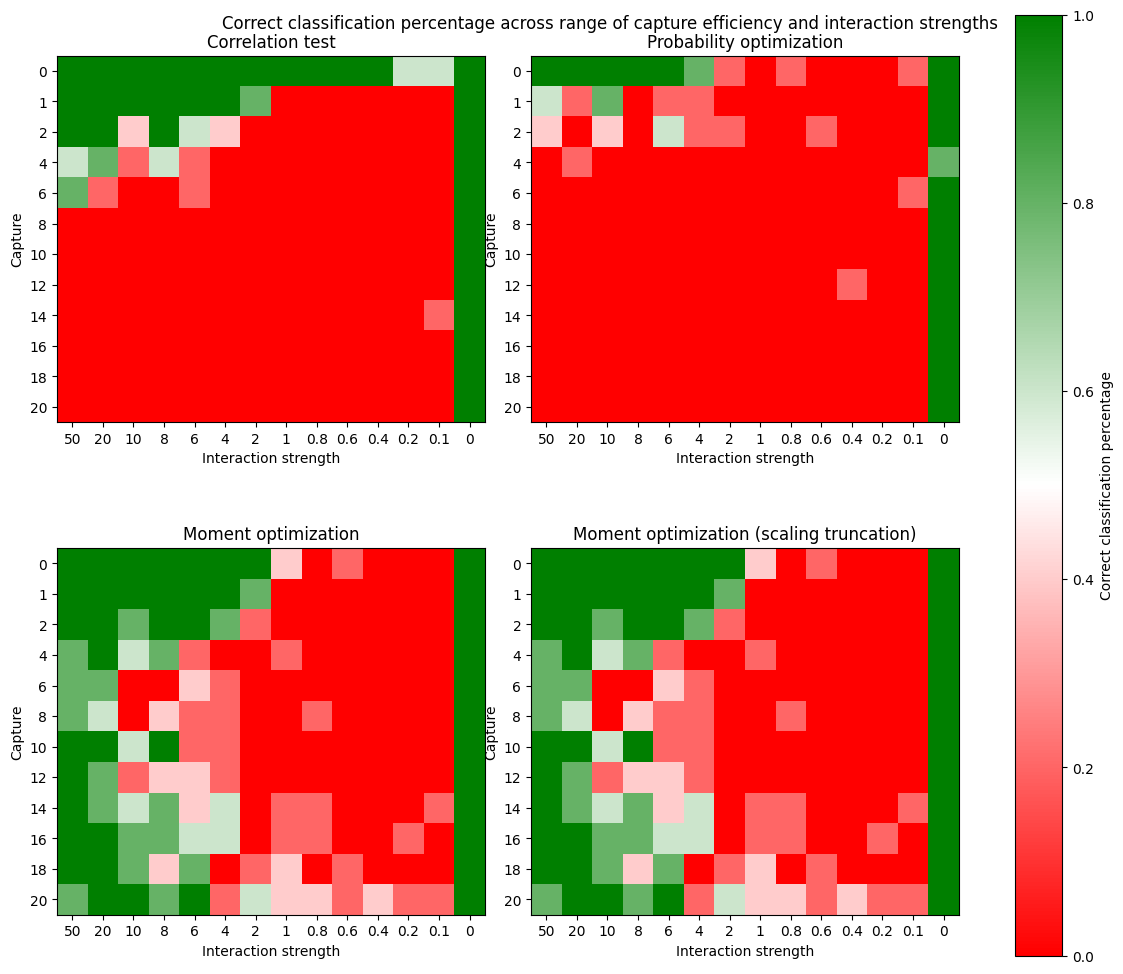

In [606]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plt.tight_layout()

from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

vmin, vmax = 0, 1

# correlation
img_corr = axs[0, 0].imshow(corr_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 0].set_xlabel("Interaction strength")
axs[0, 0].set_xticks(range(len(interaction_values)))
axs[0, 0].set_xticklabels(interaction_values)
axs[0, 0].set_ylabel("Capture")
axs[0, 0].set_yticks(range(len(capture_values)))
axs[0, 0].set_yticklabels(capture_values)
axs[0, 0].set_title("Correlation test")

# probability
img_prob = axs[0, 1].imshow(prob_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 1].set_xlabel("Interaction strength")
axs[0, 1].set_xticks(range(len(interaction_values)))
axs[0, 1].set_xticklabels(interaction_values)
axs[0, 1].set_ylabel("Capture")
axs[0, 1].set_yticks(range(len(capture_values)))
axs[0, 1].set_yticklabels(capture_values)
axs[0, 1].set_title("Probability optimization")

# moments
img_momt = axs[1, 0].imshow(momt_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 0].set_xlabel("Interaction strength")
axs[1, 0].set_xticks(range(len(interaction_values)))
axs[1, 0].set_xticklabels(interaction_values)
axs[1, 0].set_ylabel("Capture")
axs[1, 0].set_yticks(range(len(capture_values)))
axs[1, 0].set_yticklabels(capture_values)
axs[1, 0].set_title("Moment optimization")

# combined
img_moms = axs[1, 1].imshow(moms_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 1].set_xlabel("Interaction strength")
axs[1, 1].set_xticks(range(len(interaction_values)))
axs[1, 1].set_xticklabels(interaction_values)
axs[1, 1].set_ylabel("Capture")
axs[1, 1].set_yticks(range(len(capture_values)))
axs[1, 1].set_yticklabels(capture_values)
axs[1, 1].set_title("Moment optimization (scaling truncation)")

fig.suptitle("Correct classification percentage across range of capture efficiency and interaction strengths")

cbar = plt.colorbar(img_prob, ax=axs)
cbar.set_label("Correct classification percentage")

C:\Users\willi\AppData\Local\Temp\ipykernel_22700\2756538260.py:32: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 5 Axes> than <Figure size 1200x500 with 3 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(img_prob, ax=axs)


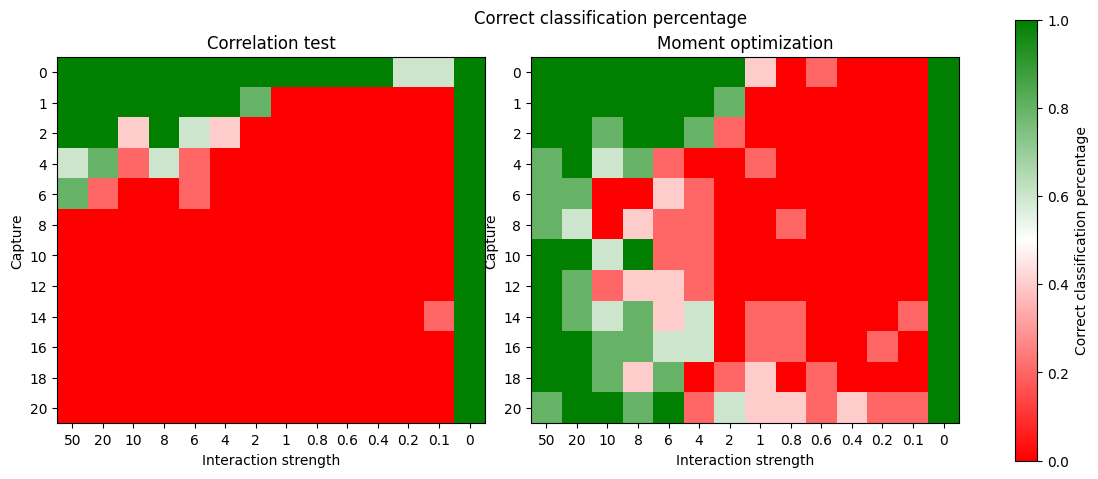

In [604]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.tight_layout()

from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

vmin, vmax = 0, 1

# correlation
img_corr = axs[0].imshow(corr_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_xlabel("Interaction strength")
axs[0].set_xticks(range(len(interaction_values)))
axs[0].set_xticklabels(interaction_values)
axs[0].set_ylabel("Capture")
axs[0].set_yticks(range(len(capture_values)))
axs[0].set_yticklabels(capture_values)
axs[0].set_title("Correlation test")

# moments
img_momt = axs[1].imshow(momt_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].set_xlabel("Interaction strength")
axs[1].set_xticks(range(len(interaction_values)))
axs[1].set_xticklabels(interaction_values)
axs[1].set_ylabel("Capture")
axs[1].set_yticks(range(len(capture_values)))
axs[1].set_yticklabels(capture_values)
axs[1].set_title("Moment optimization")

fig.suptitle("Correct classification percentage")

cbar = plt.colorbar(img_prob, ax=axs)
cbar.set_label("Correct classification percentage")

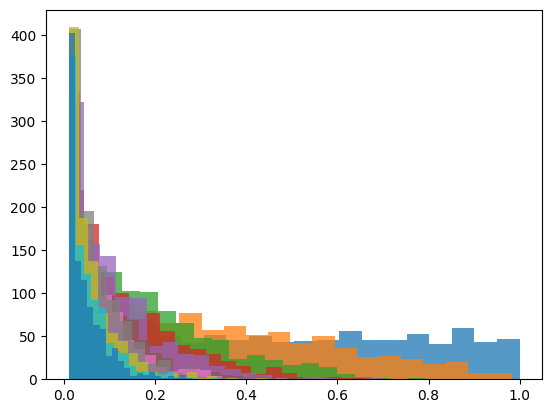

In [612]:
for capture in [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
    if capture == 0: continue
    beta = rng.beta(1, capture, size=1000)
    beta[beta < 0.01] = 0.01
    plt.hist(beta, bins=20, alpha=0.75);
    #plt.show()

## No threshold

Modify dataset processing to avoid computation of threshold trunction / coefficients / etc

In [655]:
def bootstrap_dataset_scaling(dataset, beta):

    # size
    gene_pairs, cells = dataset.shape

    # collect moment bounds
    moment_dict = {}

    # loop over samples
    for i in tqdm.tqdm(range(gene_pairs)):

        # select sample
        sample = list(dataset.loc[f'Gene-pair-{i}'])

        # bootstrap moments
        moment_results = bootstrap_moments(sample, beta)

        # store moments
        moment_dict[f'sample-{i}'] = moment_results

    return moment_dict

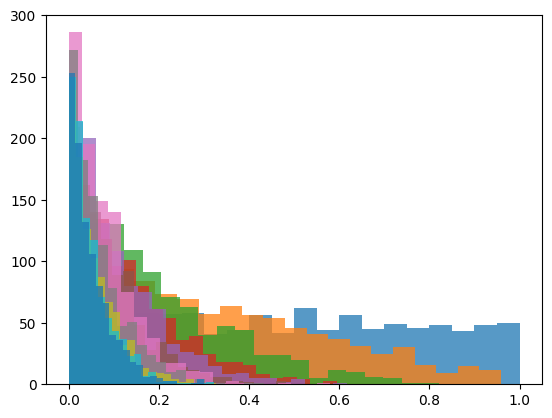

In [613]:
for capture in [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
    if capture == 0: continue
    beta = rng.beta(1, capture, size=1000)
    plt.hist(beta, bins=20, alpha=0.75);
    #plt.show()

In [644]:
# gridtest ranges
capture_values = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #[0, 1, 5, 10, 15, 20]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.8, 0.6, 0.4, 0.2, 0.1, 0]

In [659]:
# store datasets
dataset_list = []
runs = 10

# simulate original datasets
for i in range(runs):
    datasets = simulate_dataset(
        cells = 1000,
        interaction_values = interaction_values
    )
    dataset_list.append(datasets)

100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


In [660]:
# store results
corr_dict = {(capture, int_str): 0 for capture in capture_values for int_str in interaction_values}
moms_dict = {(capture, int_str): 0 for capture in capture_values for int_str in interaction_values}

# for each capture efficiency
for capture in capture_values:

    # sample capture
    if capture == 0:
        beta = np.array([1.0 for j in range(1000)])
    else:
        beta = rng.beta(1, capture, size=1000)
        '''no thresholding'''

    # for each run
    for i in range(runs):

        # downsample dataset
        counts_downsampled = simulate_downsampled_dataset(dataset_list[i]['counts_df'], beta)

        # process dataset
        moments_OB = bootstrap_dataset_scaling(counts_downsampled, beta)

        # analyse dataset
        corr_results = dataset_analysis_correlation(counts_downsampled, printing=False)
        moms_results = dataset_analysis_moments_marginal(beta, moments_OB, None, printing=False, scaling_truncation=True)

        # for each interaction strength
        for j, int_str in enumerate(interaction_values):

            # count % of correct results

            # correlation
            if (corr_results[j]['pvalue']) < 0.05 and (int_str > 0):
                corr_dict[(capture, int_str)] += 1 / runs
            elif (corr_results[j]['pvalue'] >= 0.05) and (int_str == 0):
                corr_dict[(capture, int_str)] += 1 / runs

            # moments (scaling truncation)
            if (moms_results[j] == "INFEASIBLE") and (int_str > 0):
                moms_dict[(capture, int_str)] += 1 / runs
            elif (moms_results[j] == 'OPTIMAL') and (int_str == 0):
                moms_dict[(capture, int_str)] += 1 / runs

100%|██████████| 14/14 [00:00<00:00, 21.05it/s]


In [663]:
# extract threshold info into plottable grid
corr_array = np.zeros((len(capture_values), len(interaction_values)))
moms_array = np.zeros((len(capture_values), len(interaction_values)))
for i, capture in enumerate(capture_values):
    for j, int_str in enumerate(interaction_values):
        corr_array[i, j] = corr_dict[(capture, int_str)]
        moms_array[i, j] = moms_dict[(capture, int_str)]

C:\Users\willi\AppData\Local\Temp\ipykernel_22700\2892558053.py:32: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1000 with 5 Axes> than <Figure size 1200x500 with 3 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(img_prob, ax=axs)


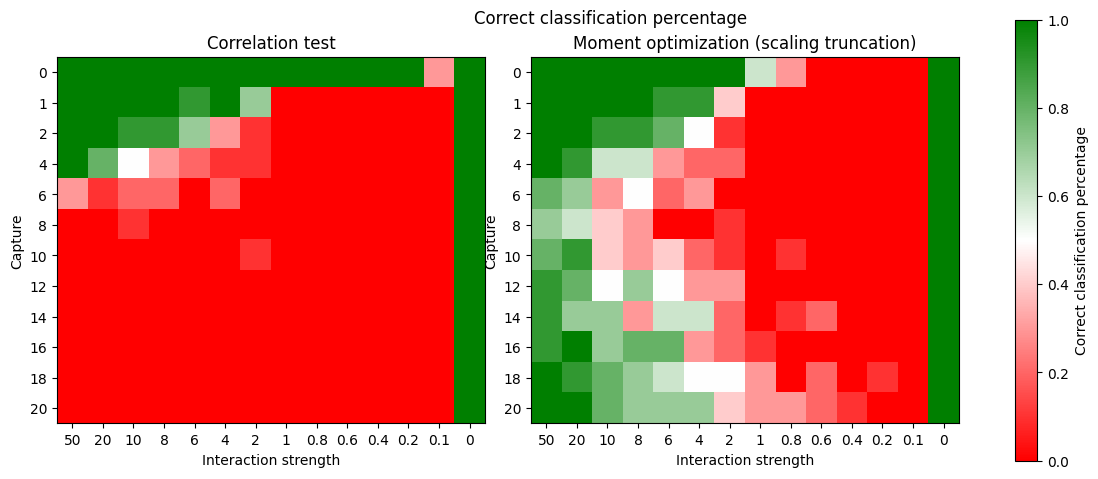

In [664]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.tight_layout()

from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

vmin, vmax = 0, 1

# correlation
img_corr = axs[0].imshow(corr_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_xlabel("Interaction strength")
axs[0].set_xticks(range(len(interaction_values)))
axs[0].set_xticklabels(interaction_values)
axs[0].set_ylabel("Capture")
axs[0].set_yticks(range(len(capture_values)))
axs[0].set_yticklabels(capture_values)
axs[0].set_title("Correlation test")

# moments
img_moms = axs[1].imshow(moms_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].set_xlabel("Interaction strength")
axs[1].set_xticks(range(len(interaction_values)))
axs[1].set_xticklabels(interaction_values)
axs[1].set_ylabel("Capture")
axs[1].set_yticks(range(len(capture_values)))
axs[1].set_yticklabels(capture_values)
axs[1].set_title("Moment optimization (scaling truncation)")

fig.suptitle("Correct classification percentage")

cbar = plt.colorbar(img_prob, ax=axs)
cbar.set_label("Correct classification percentage")